# 5FR Win Probability
### Author: Akshay Easwaran [akeaswaran@me.com](mailto:akeaswaran@me.com)

#### Prereqs/Installation
Read the README file for this repo to get the proper files downloaded and sorted locally.

#### What's Included
* Postgame win probability model -- linear regression based, predicting margin of victory based on the [Five Factors of Football](https://www.footballstudyhall.com/2014/1/24/5337968/college-football-five-factors). MoV has a normal distribution, so we can use the z-score of the predicted value to produce a win probability based on the team performance ratings generated from the statistics from the game.
* Second-order wins: sum of a team's win probabilities; how many games a team should have won given their performances
* Game Predictions (and validations): based on an adjustable number of a team's previous team performance ratings in a given year. Adjusted for P5 vs G5, overall strength of schedule, and conference strength of schedule. Note: the projected MOV produced is **NOT** adjusted by 2.5 for home-field advantage.
* Schedule analysis: charts describing a given team's performance against projections and listing projections against a given set of teams
* Team comparison charts: graphs comparing teams' 5FR rating over time
* Historic rankings: a ranking of teams based on their mean 5FR. Not adjusted for strength of schedule or conference strength.

#### Disclaimer: 
I am not responsible for any bets made using this utility.
#### License: 
MIT - See LICENSE.md for details.

In [2]:
# imports

import requests
import pandas as pd
import json
import html
import os.path
import numpy as np
from scipy import stats
%matplotlib inline
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt

In [3]:
p5 = ["SEC","Pac-12","FBS Independents","Big 12", "ACC", "Big Ten"]
g5 = ["Mountain West", "Mid-American","Sun Belt","Conference USA","American Athletic"]
fbs = p5 + g5
fbs

['SEC',
 'Pac-12',
 'FBS Independents',
 'Big 12',
 'ACC',
 'Big Ten',
 'Mountain West',
 'Mid-American',
 'Sun Belt',
 'Conference USA',
 'American Athletic']

In [4]:
def retrieveCfbData(endpoint, team, year, week, season_type):
    file_path = f"data/{endpoint if (endpoint != 'plays') else 'pbp'}/{endpoint[:-1] if (endpoint != 'plays') else 'pbp'}-data-{team.lower().replace(' ','-')}-{year}-wk{week}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/{endpoint}?seasonType={season_type}&year={year}&team={html.escape(team)}&week={week}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)

def retrieveRemoteCfbGame(game_id, year):
    file_path = f"data/games/game-data-{game_id}.json"
    if (os.path.exists(file_path)):
        return file_path
    res = requests.get(f"https://api.collegefootballdata.com/games?year={year}&seasonType=regular&id={game_id}")
    content = res.json()
#     with open(file_path, 'w') as f:
#         json.dump(content, f)
    return json.dumps(content)
    

In [5]:
# init data retrieval
teams = pd.read_csv("data/teams/2019.csv", encoding = 'latin-1')
ep_data = pd.read_csv("results/ep.csv", encoding = 'latin-1')
punt_sr_data = pd.read_csv("results/punt_sr.csv", encoding = 'latin-1')
fg_sr_data = pd.read_csv("results/fg_sr.csv", encoding = 'latin-1')

base_drives = pd.DataFrame()
games = pd.DataFrame()
pbp_data = pd.DataFrame()

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')

for i in range(2012, 2020):
    drive = retrieveCfbDataFile('drives',i)
    drive['year'] = i
    base_drives = base_drives.append(drive, sort=False)
    
    gm = retrieveCfbDataFile('games',i)
    gm['year'] = i
    games = games.append(gm, sort=False)
    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)

print(f"Total Games: {len(games)}")
print(f"Total Drives: {len(base_drives)}")
print(f"Total Plays: {len(pbp_data)}")

Total Games: 6644
Total Drives: 171692
Total Plays: 1210147


In [6]:
# Data cleaning

games.reset_index(inplace = True) 
pbp_data.reset_index(inplace = True) 
base_drives.reset_index(inplace = True) 

base_drives = base_drives[
    (~base_drives.drive_result.isin(['Uncategorized']))
]
base_drives.drop(['offense_conference','start_time.minutes','start_time.seconds','end_time.minutes','end_time.seconds','defense_conference','elapsed.seconds','elapsed.minutes'], axis = 1, inplace=True) 
drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
drives.rename(columns={'id_x':'drive_id'}, inplace=True)
drives.drop(['id_y'], axis = 1, inplace=True)
drives.dropna(inplace=True)
print(f"Clean Drives: {len(drives)}")

drives.loc[
    drives.offense == drives.away_team, ['start_yardline']
] = 100 - drives.start_yardline
drives.loc[
    drives.offense == drives.away_team, ['end_yardline']
] = 100 - drives.end_yardline
# pbp_data = pbp_data[
#     (pbp_data.down != 0)
# ]

Clean Drives: 170795


In [7]:
pbp_data.distance = pbp_data.distance.astype(float)

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Defensive 2pt Conversion","2pt Conversion","Blocked Field Goal Touchdown","Punt Return Touchdown"]
# Ignore some types of plays cause they're special teams and weird
ignore_types = ["Timeout","End of Half","End of Game","Uncategorized","Penalty","Safety","placeholder","End of Period", "End Period"]
off_play_types = pbp_data[(~(pbp_data.play_type.isin(ignore_types))) & (~(pbp_data.play_type.isin(st_types)))].play_type.drop_duplicates().tolist()
pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types)) & ~(pbp_data.play_text.str.contains("Penalty").astype(bool))]
bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']
pbp_data.loc[
    ((pbp_data.play_type.isin(bad_types)))
     & (~pbp_data.play_type.str.contains('Sack')) ,['yards_gained']] = 0

In [8]:
off_play_types

['Pass Incompletion',
 'Pass Completion',
 'Rush',
 'Sack',
 'Pass Interception',
 'Pass',
 'Pass Reception',
 'Fumble Recovery (Opponent)',
 'Fumble Recovery (Own)',
 'Passing Touchdown',
 'Rushing Touchdown',
 'Pass Interception Return',
 'Fumble Return Touchdown',
 'Interception Return Touchdown',
 'Interception',
 'Two Point Rush']

In [9]:
# %%timeit
def assign_eqppp_vector(play_type, yard_line, yards_gained):
    return 0 if (play_type in st_types) else (ep_data.iloc[max(min(100, (yard_line + yards_gained)), 0)].ep - ep_data.iloc[max(min(yard_line, 100), 0)].ep)

def assign_eqppp(x):
    return ep_data.iloc[max(min(100, (x.yard_line + x.yards_gained)), 0)].ep - ep_data.iloc[max(min(x.yard_line, 100), 0)].ep

if 'EqPPP' not in pbp_data.columns:
    pbp_data["EqPPP"] = pbp_data.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)

In [10]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,26,35,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,27,72,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,18,72,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,45,75,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,26,91,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449


In [11]:
def verify_division(num1, num2):
    if num2 == 0:
        return 0
    else:
        return num1 / num2
    
def calculate_success_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    success = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        opp_s_rate = verify_division(len(opp_set[opp_set.play_successful == True]), len(opp_set))
        success += len(opp_set[opp_set.play_successful == True])
        total += len(opp_set)
    s_rate = 0 if total == 0 else (success / total)
    return s_rate

def calculate_score_value(drv):
    if (drv.drive_result == 'TD'):
        return 7
    elif (drv.drive_result == 'FG'):
        return 3
    elif (drv.drive_result == 'SAFETY'):
        return -2
    elif ((drv.drive_result == 'INT TD') | (drv.drive_result == 'FUMBLE TD')):
        return -7
    else:
        return 0

def calculate_ppd_in_scoring_opps(opps, team):
    scores = 0
    total = len(opps)
    scores = opps.apply(lambda x: calculate_score_value(x), axis = 1)
    ppd = 0 if total == 0 else (sum(scores) / total)
    return ppd
    
def is_successful(down, distance, yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False 
    if ((down == 1) & (yards_gained >= (0.5 * distance))):
        return True
    elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
        return True
    elif ((down == 3) & (yards_gained >= distance)):
        return True
    elif ((down == 4) & (yards_gained >= distance)):
        return True
    else:
        return False
    
def is_successful_vector(play):
    if ((play.play_type in bad_types) | (play.play_type in st_types)):
        return False 
    if ((play.down == 1) & (play.yards_gained >= (0.5 * play.distance))):
        return True
    elif ((play.down == 2)) & (play.yards_gained >= (0.7 * play.distance)):
        return True
    elif ((play.down == 3) & (play.yards_gained >= play.distance)):
        return True
    elif ((play.down == 4) & (play.yards_gained >= play.distance)):
        return True
    else:
        return False

def is_explosive(yards_gained, play_type):
    if ((play_type in bad_types) | (play_type in st_types)):
        return False
    elif (yards_gained >= 15):
        return True
    else:
        return False
    
if 'play_explosive' not in pbp_data.columns:
    pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained, pbp_data.play_type)
if 'play_successful' not in pbp_data.columns:
    pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
    
def calculate_success_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_successful == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))
    
def calculate_exp_rate(pbp, exclude_types):
    return verify_division(len(pbp[(pbp.play_explosive == True) & (~pbp.play_type.isin(exclude_types))]), len(pbp[(~pbp.play_type.isin(exclude_types))]))

standard_downs = pbp_data[
    (pbp_data.down == 1)
    | ((pbp_data.down == 2) & (pbp_data.distance <= 7))
    | ((pbp_data.down == 3) & (pbp_data.distance <= 4))
    | ((pbp_data.down == 4) & (pbp_data.distance <= 4)) 
]

passing_downs = pbp_data[
    ((pbp_data.down == 2) & (pbp_data.distance >= 8))
    | ((pbp_data.down == 3) & (pbp_data.distance >= 5))
    | ((pbp_data.down == 4) & (pbp_data.distance >= 5)) 
]

def is_punt_successful(x):
    return x.Net >= punt_sr_data[punt_sr_data.Yardline == x.Yardline].ExpPuntNet.to_list()[0]

pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown","Sack"]
rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Fumble Return Touchdown']

In [12]:
pbp_data.head()

,index,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,...,down,distance,yards_gained,play_type,play_text,ppa,year,EqPPP,play_explosive,play_successful
0,0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,...,-1,-1.0,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012,0.000000,False,False
1,1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,1,10.0,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012,0.000000,False,False
2,2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,2,10.0,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012,0.254253,False,False
3,3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,...,3,7.0,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012,1.855460,True,True
4,4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,...,1,9.0,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012,1.648449,False,True


In [13]:
inputs = ['OffSR','OffER','FP','OppRate','OppEff','OppPPD','PPD','OppSR','YPP', 'ExpTO', 'ActualTO', 'AvgEqPPP', 'TotalEqPPP','IsoPPP','HavocRate','SackRate','KickoffSR','KickoffReturnSR','PuntSR','PuntReturnSR','FGEff']

# somewhat defined here: https://www.footballstudyhall.com/2014/1/27/5349762/five-factors-college-football-efficiency-explosiveness-isoppp#
def generate_iso_ppp(pbp, team):
    base_success = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.play_successful == True) & (pbp.offense == team)]
    return base_success.EqPPP.mean() #verify_division(pbp.EqPPP.sum(), len(base_success))

def calculate_isoppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set[opp_set.play_successful == True].EqPPP)
        total += len(opp_set[opp_set.play_successful == True])
    iso_ppp = 0 if total == 0 else (eq_ppp / total)
    return iso_ppp

def calculate_avgeqppp_in_scoring_opps(pbp, opps, team):
    opp_ids = opps.drive_id.unique()
    eq_ppp = 0
    total = 0
    for opp_id in opp_ids:
        opp_set = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.drive_id == opp_id) & (pbp.offense == team)]
        eq_ppp += sum(opp_set.EqPPP)
        total += len(opp_set)
    eq_ppp = 0 if total == 0 else (eq_ppp / total)
    return eq_ppp

def generate_team_play_stats(pbp, team):
    team_off_plays = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.offense == team)]
    off_sr = calculate_success_rate(team_off_plays, st_types)
    off_er = calculate_exp_rate(team_off_plays, st_types)
    ypp = verify_division(sum(team_off_plays.yards_gained), len(team_off_plays))
    iso_ppp = generate_iso_ppp(team_off_plays, team)
    avg_eqppp = team_off_plays.EqPPP.mean()
    total_eqppp = team_off_plays.EqPPP.sum()
    return pd.DataFrame({
        'team': [team],
        "OffSR": [off_sr],
        "OffER" : [off_er],
        "YPP" : [ypp],
        "IsoPPP" : [iso_ppp],
        "AvgEqPPP" : [avg_eqppp],
        "TotalEqPPP" : [total_eqppp]
    })

def generate_team_drive_stats(drvs, pbp, gm, points, team):
    team_drives = drvs[drvs.offense == team]
    scoring_opps = team_drives[
        ((team_drives.start_yardline + team_drives.yards) >= 60)
    ]
    avg_fp = verify_division(sum(team_drives.start_yardline), len(team_drives))
    ppd = verify_division(points, len(team_drives))
    opp_effcy = verify_division(len(scoring_opps[scoring_opps.scoring == True]), len(scoring_opps))
    opp_rate = verify_division(len(scoring_opps), len(team_drives))
    opp_sr = calculate_success_in_scoring_opps(pbp, scoring_opps, team)
    opp_ppd = calculate_ppd_in_scoring_opps(scoring_opps, team)
    opp_isoppp = calculate_isoppp_in_scoring_opps(pbp, scoring_opps, team)
    opp_avgeqppp = calculate_avgeqppp_in_scoring_opps(pbp, scoring_opps, team)
    return pd.DataFrame({
        'team': [team],
        'FP': [avg_fp],
        'PPD': [ppd],
        'OppEff': [opp_effcy],
        'OppRate': [opp_rate],
        'OppSR': [opp_sr],
        'OppPPD': [opp_ppd],
        'OppIsoPPP' : [opp_isoppp],
        'OppAvgEqPPP' : [opp_isoppp]
    })

def calculate_havoc_rate(pbp, team):
    team_havoc = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type == 'Fumble Recovery (Opponent)')
        | (pbp.play_type == 'Sack')
        | (pbp.play_type.str.contains('Interception', regex=False))
        | (pbp.yards_gained < 0))
        & (pbp.play_type != 'Penalty'))]
    return verify_division(len(team_havoc), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def calculate_sack_rate(pbp, team):
    team_sack = pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team) & ((pbp.play_type == 'Sack'))]
    return verify_division(len(team_sack), len(pbp[(pbp.play_type.isin(off_play_types)) & (pbp.defense == team)]))

def generate_team_turnover_stats(pbp, team):
    adj_turnover_plays = pbp[
        (pbp.play_type.str.contains('Interception', regex=False))
        | ((pbp.play_type == 'Pass Incompletion')
        & (pbp.play_text.str.contains('broken up', regex=False)))
        | (pbp.play_type.str.contains('Fumble', regex=False))
    ]

    fum_plays = adj_turnover_plays[
        (adj_turnover_plays.play_type.str.contains('Fumble', regex=False))
    ]

    # away_team Adj Turnovers
    team_tos = adj_turnover_plays[
        (adj_turnover_plays.offense == team)
        | (adj_turnover_plays.defense == team)
    ]

    team_ints_off = team_tos[
       (team_tos.play_type.str.contains('Interception', regex=False))
        & (team_tos.offense == team)
    ]

    team_pds = team_tos[
       (team_tos.play_type == 'Pass Incompletion')
        & (team_tos.play_text.str.contains('broken up', regex=False))
        & (team_tos.offense == team)
    ]
    
    exp_to = (0.22 * (len(team_pds) + len(team_ints_off))) + (0.49 * len(fum_plays))
    actual_to = len(team_ints_off) + len(fum_plays[(fum_plays.offense == team) & (fum_plays.play_type.str.contains('Fumble Recovery (Opponent)', regex=False))])
    havoc = calculate_havoc_rate(pbp, team)
    sack = calculate_sack_rate(pbp, team)

    return pd.DataFrame({
        'team' : [team],
        'ExpTO': [exp_to],
        'ActualTO' : [actual_to],
        'HavocRate': [havoc],
        'SackRate': [sack]
    })

st_types = ["Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt","Field Goal Good","Field Goal Missed"]
def generate_team_st_stats(pbp, team):
    st_plays = pbp[(pbp.play_type.isin(st_types))]
    
    fg_plays = st_plays[st_plays.play_type.str.contains("Field Goal") & (st_plays.offense == team)]
    fg_made = fg_plays[fg_plays.play_type.str.contains("Good")]
    fg_eff = verify_division(len(fg_made), len(fg_plays))
    
    xp_plays = st_plays[st_plays.play_type.str.contains("Extra Point") & (st_plays.offense == team)]
    xp_made = xp_plays[xp_plays.play_type.str.contains("Good")]
    xp_eff = verify_division(len(xp_made), len(xp_plays))
    
    kickoff_plays = st_plays[st_plays.play_type.str.contains("Kickoff") & ~(st_plays.play_text.str.contains("on-side"))]
    tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))
    kickoff_distance = pd.DataFrame(columns=["Index","Yardline","Offense","Defense","PlayText","Distance","Return","Net"])
    if (len(tmp) > 0):
        kickoff_distance["Index"] = tmp.index
        kickoff_distance["Offense"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
        kickoff_distance["Defense"] = kickoff_distance.apply(lambda x: kickoff_plays.defense[x.Index],axis=1)
        kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (kickoff_plays.yard_line[x.Index] % 50)),axis=1)
        kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
        kickoff_distance["Distance"] = tmp.values
        kickoff_distance["Return"] = kickoff_distance.apply(lambda x: kickoff_plays.yards_gained[x.Index],axis=1)
        kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
    kickoff_sr = verify_division(len(kickoff_distance[(kickoff_distance.Net >= 40) & (kickoff_distance.Offense == team)]), len(kickoff_distance[(kickoff_distance.Offense == team)]))
    kick_return_sr = verify_division(len(kickoff_distance[(kickoff_distance.Return >= 24) & (kickoff_distance.Defense == team)]), len(kickoff_distance[(kickoff_distance.Defense == team)]))
    
    punt_plays = st_plays[st_plays.play_type.str.contains("Punt")]
    pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
    punt_distance = pd.DataFrame(columns=["Index","Offense","Defense","Yardline","Distance","Return","Net","Successful"])
    if (len(pt_tmp) > 0):
        punt_distance["Index"] = pt_tmp.index
        punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
        punt_distance["Defense"] = punt_distance.apply(lambda x: punt_plays.defense[x.Index],axis=1)
        punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else (50 - (punt_plays.yard_line[x.Index] % 50)),axis=1)
        punt_distance["Distance"] = pt_tmp.values
        punt_distance["Return"] = punt_distance.apply(lambda x: punt_plays.yards_gained[x.Index],axis=1)
        punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
        punt_distance['Successful'] = punt_distance.apply(lambda x: is_punt_successful(x), axis=1)
        
    punt_sr = verify_division(len(punt_distance[(punt_distance.Successful == True) & (punt_distance.Offense == team)]), len(punt_distance[(punt_distance.Offense == team)]))
    punt_return_sr = verify_division(len(punt_distance[(punt_distance.Successful == False) & (punt_distance.Defense == team)]), len(punt_distance[(punt_distance.Defense == team)]))
    
    return pd.DataFrame({
        'team' : [team],
        'FGEff': [fg_eff],
        'XPEff' : [xp_eff],
        'KickoffSR' : [kickoff_sr],
        'KickoffReturnSR' : [kick_return_sr],
        'PuntSR' : [punt_sr],
        'PuntReturnSR' : [punt_return_sr]
    })

def stringify_entry(team_entry):
    entries = team_entry.tolist()
    return entries[0]

def translate(value, inputMin, inputMax, outputMin, outputMax):
    leftSpan = inputMax - inputMin
    rightSpan = outputMax - outputMin

    # Convert the left range into a 0-1 range (float)
    valueScaled = float(value - inputMin) / float(leftSpan)

    # Convert the 0-1 range into a value in the right range.
    return outputMin + (valueScaled * rightSpan)

def create_expl_index(team_stat_pack):
    return translate(team_stat_pack.AvgEqPPPDiff, pbp_data.EqPPP.min()-pbp_data.EqPPP.max(), pbp_data.EqPPP.max()-pbp_data.EqPPP.min(), 0, 10)

def create_eff_index(team_stat_pack):
    return translate(team_stat_pack.OffSRDiff, -1, 1, 0, 10)

def create_fp_index(team_stat_pack):
    return translate(team_stat_pack.FPDiff, -50, 50, 0, 10)

def create_finish_drive_index(team_stat_pack):
    return translate(team_stat_pack.OppPPDDiff, -7,7,0,3.5) + translate(team_stat_pack.OppRateDiff, -1, 1, 0, 4) + translate(team_stat_pack.OppSRDiff, -1,1,0,2.5)

def create_turnover_index(team_stat_pack):
    return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 3) + translate(team_stat_pack.SackRateDiff, -1, 1, 0, 3) + translate(team_stat_pack.HavocRateDiff, -1, 1, 0, 4)
    #return translate(team_stat_pack.ExpTODiff - team_stat_pack.ActualTODiff, -5, 5, 0, 10)

def calculate_five_factors_rating(team_stat_pack):
    return 0.35 * create_eff_index(team_stat_pack) + 0.30 * create_expl_index(team_stat_pack) + 0.15 * create_finish_drive_index(team_stat_pack) + 0.10 * create_fp_index(team_stat_pack) + 0.10 * create_turnover_index(team_stat_pack)

def createDiffs(home, away, column):
    home[f"{column}Diff"] = home[column] - away[column]
    away[f"{column}Diff"] = away[column] - home[column]

def calculate_box_score(game_id, year):
    game_data = games[games.id == game_id]
    
    if (len(game_data) == 0):
        print(f"Could not find basic game data for game_id {game_id} locally, checking CFB Data API")
        game_data = pd.read_json(retrieveRemoteCfbGame(game_id, year))
        if (len(game_data) == 0):
            print(f"Could not find basic game data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    home_team = stringify_entry(game_data.home_team)
    away_team = stringify_entry(game_data.away_team)
    home_score = stringify_entry(game_data.home_points)
    away_score = stringify_entry(game_data.away_points)
    
    game_year = stringify_entry(game_data.season)
    game_week = stringify_entry(game_data.week)
    season_type = stringify_entry(game_data.season_type)
    
    game_drives = drives[drives.game_id == game_id]
    if ((len(game_drives) == 0)):
        print(f"Could not find drive data for game_id {game_id} locally, checking CFB Data API")
        if ((year == 2016) | (year == 2014)):
            print(f"Could not find drive data for game_id {game_id} bc of issues with 2016 and 2014 data source, bailing out")
            return None
        else:
            game_drives = pd.read_json(retrieveCfbData('drives', home_team, game_year, game_week, season_type))
            if (len(game_drives) == 0):
                print(f"Could not find drive data for game_id {game_id} on CFB Data API, bailing out")
                return None
            else:
                game_drives = pd.merge(game_drives, game_data[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
                game_drives.rename(columns={'id_x':'drive_id'}, inplace=True)
                game_drives.drop(['id_y'], axis = 1, inplace=True)
                game_drives.dropna(inplace=True)

                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['start_yardline']
                ] = 100 - game_drives.start_yardline
                game_drives.loc[
                    game_drives.offense == game_drives.away_team, ['end_yardline']
                ] = 100 - game_drives.end_yardline
    
    game_pbp = pbp_data[pbp_data.drive_id.isin(game_drives.drive_id.tolist())]
    if (len(game_pbp) == 0):
        print(f"Could not find play by play data for game_id {game_id} locally, checking CFB Data API")
        game_pbp = pd.read_json(retrieveCfbData('plays', home_team, game_year, game_week, season_type))
        if (len(game_pbp) == 0):
            print(f"Could not find play by play data for game_id {game_id} on CFB Data API, bailing out")
            return None
    
    if 'play_explosive' not in game_pbp.columns:
        game_pbp['play_explosive'] = np.vectorize(is_explosive)(game_pbp.yards_gained, game_pbp.play_type)
    if 'play_successful' not in game_pbp.columns:
        game_pbp['play_successful'] = np.vectorize(is_successful)(game_pbp.down, game_pbp.distance, game_pbp.yards_gained, game_pbp.play_type)
    if 'EqPPP' not in game_pbp.columns:
        game_pbp['EqPPP'] = game_pbp.apply(lambda x: 0 if (x.play_type in st_types) else assign_eqppp(x), axis=1)
        
    home_team_play_stats = generate_team_play_stats(game_pbp, home_team)
    away_team_play_stats = generate_team_play_stats(game_pbp, away_team)
    
    home_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, home_score, home_team)
    away_team_drv_stats = generate_team_drive_stats(game_drives, game_pbp, game_data, away_score, away_team)
    
    home_team_stats = pd.merge(home_team_play_stats, home_team_drv_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_play_stats, away_team_drv_stats, left_on="team", right_on="team", how='right')

    home_team_tos = generate_team_turnover_stats(game_pbp, home_team)
    away_team_tos = generate_team_turnover_stats(game_pbp, away_team)
    home_team_stats = pd.merge(home_team_stats, home_team_tos, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_tos, left_on="team", right_on="team", how='right')
    
    home_team_st_stats = generate_team_st_stats(game_pbp, home_team)
    away_team_st_stats = generate_team_st_stats(game_pbp, away_team)
    
    home_team_stats = pd.merge(home_team_stats, home_team_st_stats, left_on="team", right_on="team", how='right')
    away_team_stats = pd.merge(away_team_stats, away_team_st_stats, left_on="team", right_on="team", how='right')
    
    for inpt in inputs:
        createDiffs(home_team_stats, away_team_stats, inpt)
    
    home_team_stats['5FR'] = calculate_five_factors_rating(home_team_stats)
    away_team_stats['5FR'] = calculate_five_factors_rating(away_team_stats)
    home_team_stats['5FRDiff'] = home_team_stats['5FR'] - away_team_stats['5FR']
    away_team_stats['5FRDiff'] = away_team_stats['5FR'] - home_team_stats['5FR']
    
    comb_stat_pack = away_team_stats.append(home_team_stats)
    
    box = pd.DataFrame({
        "team" : [away_team, home_team],
        "Season": [game_year, game_year],
        "GameID": [game_id, game_id],
        "Pts" : [away_score, home_score],
        "PtsDiff" : [away_score - home_score, home_score - away_score],
        "CfbDataWinProb" : [stringify_entry(game_data.away_post_win_prob),stringify_entry(game_data.home_post_win_prob)]
    })
    
    box = pd.merge(box, comb_stat_pack, left_on="team", right_on="team", how="right")
    box.rename(columns={"team": "Team"}, inplace=True)
    
    return box
box_score = calculate_box_score(401013183, 2018)
box_score

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [14]:
def break_down_box_score(box):
    box_comps = pd.DataFrame(data={'Team':box.Team})
    box_comps['Eff'] = box.apply(lambda x: create_eff_index(x), axis=1)
    box_comps['Expl'] = box.apply(lambda x: create_expl_index(x), axis=1)
    box_comps['FinDrv'] = box.apply(lambda x: create_finish_drive_index(x), axis=1)
    box_comps['FldPos'] = box.apply(lambda x: create_fp_index(x), axis=1)
    box_comps['Trnovr'] = box.apply(lambda x: create_turnover_index(x), axis=1)
    box_comps['5FR'] = box['5FR']
    box_comps['5FRDiff'] = box['5FRDiff']
    return box_comps
break_down_box_score(box_score)

,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Virginia,5.142022,5.050452,5.386628,4.46,5.017309,5.070568,0.141137
1,Virginia Tech,4.857978,4.949548,4.613372,5.54,4.982691,4.929432,-0.141137


In [15]:
# %%timeit
import os.path
from os import path

game_ids = games.id.unique()
team_list = teams[teams.conference.isin(fbs)].school.tolist()
if ('stored_game_boxes' not in locals()) & (~path.exists("results/box-scores.csv")):
    print(f"[Local] Box Scores are not available, generating them from scratch...")
    stored_game_boxes = pd.DataFrame()
    for i, row in games.iterrows():
        gameId = row.id
        print(f"[{i+1}/{len(game_ids)}] Getting game information for ESPN game_id: {gameId}...")
        print(f"[{i+1}/{len(game_ids)}] Started processing game information for ESPN game_id: {gameId}...")
        if ((row.home_team in team_list) & (row.away_team in team_list)):
            box_score = calculate_box_score(gameId, row.season)
            if (box_score is not None):
                print(f"[{i+1}/{len(game_ids)}] Completed processing game information for ESPN game_id: {gameId}.")
                stored_game_boxes = stored_game_boxes.append(box_score)
                print(f"[{i+1}/{len(game_ids)}] Aggreggated game_id {gameId} to master data copy.")
            else:
                print(f"[{i+1}/{len(game_ids)}] Got 'None' for game_id {gameId}'s box score, skipping processing.")
        else:
            print(f"[{i+1}/{len(game_ids)}] Skipping checking game_id {gameId} bc one of the teams isn't FBS.")
    print(f"[Local] Finished generating {len(stored_game_boxes)} box scores and 5FR margins from scratch.")
else:
    proceed = True
    if ('stored_game_boxes' in locals()):
        print(f"Relying on 'stored_game_boxes' currently loaded into memory")
    elif (path.exists("results/box-scores.csv")):
        print(f"Loading box scores from file...")
        stored_game_boxes = pd.read_csv("results/box-scores.csv", encoding="latin-1")
    else:
        print(f"[Local] No box scores available, bailing out...")
        proceed = False
        
    if (proceed == True):
        print(f"[Local] Box Scores are available in local, updating five factors ratings now...")
        stored_game_boxes['5FR'] = stored_game_boxes.apply(lambda row: calculate_five_factors_rating(row), axis=1)
        print(f"[Local] Grouping box score rows by GameID...")
        groups = stored_game_boxes.groupby('GameID')
        print(f"[Local] Generated {len(groups)} box score groups by GameID.")
        current = 0
        for (name, group) in groups:
            print(f"[{current+1}/{len(groups)}] Updating 5FR Margin for game_id {name}...")
            group_ratings = group['5FR']
            top_diff = group_ratings.iloc[0] - group_ratings.iloc[1]
            bot_diff = group_ratings.iloc[1] - group_ratings.iloc[0]
            group['5FRDiff'] = [top_diff, bot_diff]
            print(f"[{current+1}/{len(groups)}] Updated 5FR Margin for game_id {name}.")
            current+=1
        print(f"[Local] Finished updating box scores with new 5FR margins.")

if ('stored_game_boxes' in locals()):
    print(f"[Local] Writing updated box scores to file...")
    stored_game_boxes.dropna(inplace=True)
    stored_game_boxes.to_csv("results/box-scores.csv", index=False, sep=",")
    print(f"[Local] Wrote updated box scores to file.")
    stored_game_boxes.head()

Loading box scores from file...
[Local] Box Scores are available in local, updating five factors ratings now...
[Local] Grouping box score rows by GameID...
[Local] Generated 5670 box score groups by GameID.
[1/5670] Updating 5FR Margin for game_id 322430041...
[1/5670] Updated 5FR Margin for game_id 322430041.
[2/5670] Updating 5FR Margin for game_id 322430238...
[2/5670] Updated 5FR Margin for game_id 322430238.
[3/5670] Updating 5FR Margin for game_id 322430242...
[3/5670] Updated 5FR Margin for game_id 322430242.
[4/5670] Updating 5FR Margin for game_id 322430252...
[4/5670] Updated 5FR Margin for game_id 322430252.
[5/5670] Updating 5FR Margin for game_id 322432006...
[5/5670] Updated 5FR Margin for game_id 322432006.
[6/5670] Updating 5FR Margin for game_id 322432050...
[6/5670] Updated 5FR Margin for game_id 322432050.
[7/5670] Updating 5FR Margin for game_id 322432439...


/Users/akeaswaran/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


[7/5670] Updated 5FR Margin for game_id 322432439.
[8/5670] Updating 5FR Margin for game_id 322440024...
[8/5670] Updated 5FR Margin for game_id 322440024.
[9/5670] Updating 5FR Margin for game_id 322440127...
[9/5670] Updated 5FR Margin for game_id 322440127.
[10/5670] Updating 5FR Margin for game_id 322442633...
[10/5670] Updated 5FR Margin for game_id 322442633.
[11/5670] Updating 5FR Margin for game_id 322450002...
[11/5670] Updated 5FR Margin for game_id 322450002.
[12/5670] Updating 5FR Margin for game_id 322450005...
[12/5670] Updated 5FR Margin for game_id 322450005.
[13/5670] Updating 5FR Margin for game_id 322450012...
[13/5670] Updated 5FR Margin for game_id 322450012.
[14/5670] Updating 5FR Margin for game_id 322450025...
[14/5670] Updated 5FR Margin for game_id 322450025.
[15/5670] Updating 5FR Margin for game_id 322450030...
[15/5670] Updated 5FR Margin for game_id 322450030.
[16/5670] Updating 5FR Margin for game_id 322450038...
[16/5670] Updated 5FR Margin for game_id 3

[91/5670] Updated 5FR Margin for game_id 322590023.
[92/5670] Updating 5FR Margin for game_id 322590024...
[92/5670] Updated 5FR Margin for game_id 322590024.
[93/5670] Updating 5FR Margin for game_id 322590026...
[93/5670] Updated 5FR Margin for game_id 322590026.
[94/5670] Updating 5FR Margin for game_id 322590052...
[94/5670] Updated 5FR Margin for game_id 322590052.
[95/5670] Updating 5FR Margin for game_id 322590059...
[95/5670] Updated 5FR Margin for game_id 322590059.
[96/5670] Updating 5FR Margin for game_id 322590061...
[96/5670] Updated 5FR Margin for game_id 322590061.
[97/5670] Updating 5FR Margin for game_id 322590068...
[97/5670] Updated 5FR Margin for game_id 322590068.
[98/5670] Updating 5FR Margin for game_id 322590077...
[98/5670] Updated 5FR Margin for game_id 322590077.
[99/5670] Updating 5FR Margin for game_id 322590084...
[99/5670] Updated 5FR Margin for game_id 322590084.
[100/5670] Updating 5FR Margin for game_id 322590096...
[100/5670] Updated 5FR Margin for ga

[176/5670] Updated 5FR Margin for game_id 322662628.
[177/5670] Updating 5FR Margin for game_id 322662633...
[177/5670] Updated 5FR Margin for game_id 322662633.
[178/5670] Updating 5FR Margin for game_id 322662649...
[178/5670] Updated 5FR Margin for game_id 322662649.
[179/5670] Updating 5FR Margin for game_id 322662711...
[179/5670] Updated 5FR Margin for game_id 322662711.
[180/5670] Updating 5FR Margin for game_id 322710264...
[180/5670] Updated 5FR Margin for game_id 322710264.
[181/5670] Updating 5FR Margin for game_id 322720252...
[181/5670] Updated 5FR Margin for game_id 322720252.
[182/5670] Updating 5FR Margin for game_id 322730005...
[182/5670] Updated 5FR Margin for game_id 322730005.
[183/5670] Updating 5FR Margin for game_id 322730006...
[183/5670] Updated 5FR Margin for game_id 322730006.
[184/5670] Updating 5FR Margin for game_id 322730012...
[184/5670] Updated 5FR Margin for game_id 322730012.
[185/5670] Updating 5FR Margin for game_id 322730025...
[185/5670] Updated 

[256/5670] Updated 5FR Margin for game_id 322800248.
[257/5670] Updating 5FR Margin for game_id 322800251...
[257/5670] Updated 5FR Margin for game_id 322800251.
[258/5670] Updating 5FR Margin for game_id 322800275...
[258/5670] Updated 5FR Margin for game_id 322800275.
[259/5670] Updating 5FR Margin for game_id 322800276...
[259/5670] Updated 5FR Margin for game_id 322800276.
[260/5670] Updating 5FR Margin for game_id 322800309...
[260/5670] Updated 5FR Margin for game_id 322800309.
[261/5670] Updating 5FR Margin for game_id 322800349...
[261/5670] Updated 5FR Margin for game_id 322800349.
[262/5670] Updating 5FR Margin for game_id 322802005...
[262/5670] Updated 5FR Margin for game_id 322802005.
[263/5670] Updating 5FR Margin for game_id 322802006...
[263/5670] Updated 5FR Margin for game_id 322802006.
[264/5670] Updating 5FR Margin for game_id 322802050...
[264/5670] Updated 5FR Margin for game_id 322802050.
[265/5670] Updating 5FR Margin for game_id 322802132...
[265/5670] Updated 

[336/5670] Updated 5FR Margin for game_id 322940006.
[337/5670] Updating 5FR Margin for game_id 322940012...
[337/5670] Updated 5FR Margin for game_id 322940012.
[338/5670] Updating 5FR Margin for game_id 322940025...
[338/5670] Updated 5FR Margin for game_id 322940025.
[339/5670] Updating 5FR Margin for game_id 322940030...
[339/5670] Updated 5FR Margin for game_id 322940030.
[340/5670] Updating 5FR Margin for game_id 322940057...
[340/5670] Updated 5FR Margin for game_id 322940057.
[341/5670] Updating 5FR Margin for game_id 322940059...
[341/5670] Updated 5FR Margin for game_id 322940059.
[342/5670] Updating 5FR Margin for game_id 322940068...
[342/5670] Updated 5FR Margin for game_id 322940068.
[343/5670] Updating 5FR Margin for game_id 322940077...
[343/5670] Updated 5FR Margin for game_id 322940077.
[344/5670] Updating 5FR Margin for game_id 322940087...
[344/5670] Updated 5FR Margin for game_id 322940087.
[345/5670] Updating 5FR Margin for game_id 322940096...
[345/5670] Updated 

[416/5670] Updated 5FR Margin for game_id 323010201.
[417/5670] Updating 5FR Margin for game_id 323010213...
[417/5670] Updated 5FR Margin for game_id 323010213.
[418/5670] Updating 5FR Margin for game_id 323010221...
[418/5670] Updated 5FR Margin for game_id 323010221.
[419/5670] Updating 5FR Margin for game_id 323010238...
[419/5670] Updated 5FR Margin for game_id 323010238.
[420/5670] Updating 5FR Margin for game_id 323010242...
[420/5670] Updated 5FR Margin for game_id 323010242.
[421/5670] Updating 5FR Margin for game_id 323010248...
[421/5670] Updated 5FR Margin for game_id 323010248.
[422/5670] Updating 5FR Margin for game_id 323010254...
[422/5670] Updated 5FR Margin for game_id 323010254.
[423/5670] Updating 5FR Margin for game_id 323010264...
[423/5670] Updated 5FR Margin for game_id 323010264.
[424/5670] Updating 5FR Margin for game_id 323010275...
[424/5670] Updated 5FR Margin for game_id 323010275.
[425/5670] Updating 5FR Margin for game_id 323010276...
[425/5670] Updated 

[498/5670] Updated 5FR Margin for game_id 323082751.
[499/5670] Updating 5FR Margin for game_id 323112649...
[499/5670] Updated 5FR Margin for game_id 323112649.
[500/5670] Updating 5FR Margin for game_id 323120195...
[500/5670] Updated 5FR Margin for game_id 323120195.
[501/5670] Updating 5FR Margin for game_id 323130259...
[501/5670] Updated 5FR Margin for game_id 323130259.
[502/5670] Updating 5FR Margin for game_id 323132032...
[502/5670] Updated 5FR Margin for game_id 323132032.
[503/5670] Updating 5FR Margin for game_id 323140041...
[503/5670] Updated 5FR Margin for game_id 323140041.
[504/5670] Updating 5FR Margin for game_id 323150002...
[504/5670] Updated 5FR Margin for game_id 323150002.
[505/5670] Updating 5FR Margin for game_id 323150005...
[505/5670] Updated 5FR Margin for game_id 323150005.
[506/5670] Updating 5FR Margin for game_id 323150012...
[506/5670] Updated 5FR Margin for game_id 323150012.
[507/5670] Updating 5FR Margin for game_id 323150021...
[507/5670] Updated 

[578/5670] Updated 5FR Margin for game_id 323220202.
[579/5670] Updating 5FR Margin for game_id 323220204...
[579/5670] Updated 5FR Margin for game_id 323220204.
[580/5670] Updating 5FR Margin for game_id 323220213...
[580/5670] Updated 5FR Margin for game_id 323220213.
[581/5670] Updating 5FR Margin for game_id 323220228...
[581/5670] Updated 5FR Margin for game_id 323220228.
[582/5670] Updating 5FR Margin for game_id 323220238...
[582/5670] Updated 5FR Margin for game_id 323220238.
[583/5670] Updating 5FR Margin for game_id 323220239...
[583/5670] Updated 5FR Margin for game_id 323220239.
[584/5670] Updating 5FR Margin for game_id 323220242...
[584/5670] Updated 5FR Margin for game_id 323220242.
[585/5670] Updating 5FR Margin for game_id 323220254...
[585/5670] Updated 5FR Margin for game_id 323220254.
[586/5670] Updating 5FR Margin for game_id 323220275...
[586/5670] Updated 5FR Margin for game_id 323220275.
[587/5670] Updating 5FR Margin for game_id 323220276...
[587/5670] Updated 

[656/5670] Updated 5FR Margin for game_id 323292567.
[657/5670] Updating 5FR Margin for game_id 323292633...
[657/5670] Updated 5FR Margin for game_id 323292633.
[658/5670] Updating 5FR Margin for game_id 323292636...
[658/5670] Updated 5FR Margin for game_id 323292636.
[659/5670] Updating 5FR Margin for game_id 323292638...
[659/5670] Updated 5FR Margin for game_id 323292638.
[660/5670] Updating 5FR Margin for game_id 323292641...
[660/5670] Updated 5FR Margin for game_id 323292641.
[661/5670] Updating 5FR Margin for game_id 323292751...
[661/5670] Updated 5FR Margin for game_id 323292751.
[662/5670] Updating 5FR Margin for game_id 323340164...
[662/5670] Updated 5FR Margin for game_id 323340164.
[663/5670] Updating 5FR Margin for game_id 323350024...
[663/5670] Updated 5FR Margin for game_id 323350024.
[664/5670] Updating 5FR Margin for game_id 323352309...
[664/5670] Updated 5FR Margin for game_id 323352309.
[665/5670] Updating 5FR Margin for game_id 323360041...
[665/5670] Updated 

[735/5670] Updated 5FR Margin for game_id 332500096.
[736/5670] Updating 5FR Margin for game_id 332500099...
[736/5670] Updated 5FR Margin for game_id 332500099.
[737/5670] Updating 5FR Margin for game_id 332500120...
[737/5670] Updated 5FR Margin for game_id 332500120.
[738/5670] Updating 5FR Margin for game_id 332500127...
[738/5670] Updated 5FR Margin for game_id 332500127.
[739/5670] Updating 5FR Margin for game_id 332500130...
[739/5670] Updated 5FR Margin for game_id 332500130.
[740/5670] Updating 5FR Margin for game_id 332500142...
[740/5670] Updated 5FR Margin for game_id 332500142.
[741/5670] Updating 5FR Margin for game_id 332500153...
[741/5670] Updated 5FR Margin for game_id 332500153.
[742/5670] Updating 5FR Margin for game_id 332500158...
[742/5670] Updated 5FR Margin for game_id 332500158.
[743/5670] Updating 5FR Margin for game_id 332500166...
[743/5670] Updated 5FR Margin for game_id 332500166.
[744/5670] Updating 5FR Margin for game_id 332500194...
[744/5670] Updated 

[815/5670] Updated 5FR Margin for game_id 332640030.
[816/5670] Updating 5FR Margin for game_id 332640041...
[816/5670] Updated 5FR Margin for game_id 332640041.
[817/5670] Updating 5FR Margin for game_id 332640057...
[817/5670] Updated 5FR Margin for game_id 332640057.
[818/5670] Updating 5FR Margin for game_id 332640059...
[818/5670] Updated 5FR Margin for game_id 332640059.
[819/5670] Updating 5FR Margin for game_id 332640061...
[819/5670] Updated 5FR Margin for game_id 332640061.
[820/5670] Updating 5FR Margin for game_id 332640084...
[820/5670] Updated 5FR Margin for game_id 332640084.
[821/5670] Updating 5FR Margin for game_id 332640087...
[821/5670] Updated 5FR Margin for game_id 332640087.
[822/5670] Updating 5FR Margin for game_id 332640097...
[822/5670] Updated 5FR Margin for game_id 332640097.
[823/5670] Updating 5FR Margin for game_id 332640099...
[823/5670] Updated 5FR Margin for game_id 332640099.
[824/5670] Updating 5FR Margin for game_id 332640113...
[824/5670] Updated 

[904/5670] Updated 5FR Margin for game_id 332770328.
[905/5670] Updating 5FR Margin for game_id 332780002...
[905/5670] Updated 5FR Margin for game_id 332780002.
[906/5670] Updating 5FR Margin for game_id 332780005...
[906/5670] Updated 5FR Margin for game_id 332780005.
[907/5670] Updating 5FR Margin for game_id 332780024...
[907/5670] Updated 5FR Margin for game_id 332780024.
[908/5670] Updating 5FR Margin for game_id 332780025...
[908/5670] Updated 5FR Margin for game_id 332780025.
[909/5670] Updating 5FR Margin for game_id 332780038...
[909/5670] Updated 5FR Margin for game_id 332780038.
[910/5670] Updating 5FR Margin for game_id 332780052...
[910/5670] Updated 5FR Margin for game_id 332780052.
[911/5670] Updating 5FR Margin for game_id 332780057...
[911/5670] Updated 5FR Margin for game_id 332780057.
[912/5670] Updating 5FR Margin for game_id 332780058...
[912/5670] Updated 5FR Margin for game_id 332780058.
[913/5670] Updating 5FR Margin for game_id 332780062...
[913/5670] Updated 

[983/5670] Updated 5FR Margin for game_id 332850265.
[984/5670] Updating 5FR Margin for game_id 332850275...
[984/5670] Updated 5FR Margin for game_id 332850275.
[985/5670] Updating 5FR Margin for game_id 332850326...
[985/5670] Updated 5FR Margin for game_id 332850326.
[986/5670] Updating 5FR Margin for game_id 332850328...
[986/5670] Updated 5FR Margin for game_id 332850328.
[987/5670] Updating 5FR Margin for game_id 332850344...
[987/5670] Updated 5FR Margin for game_id 332850344.
[988/5670] Updating 5FR Margin for game_id 332850349...
[988/5670] Updated 5FR Margin for game_id 332850349.
[989/5670] Updating 5FR Margin for game_id 332852050...
[989/5670] Updated 5FR Margin for game_id 332852050.
[990/5670] Updating 5FR Margin for game_id 332852226...
[990/5670] Updated 5FR Margin for game_id 332852226.
[991/5670] Updating 5FR Margin for game_id 332852229...
[991/5670] Updated 5FR Margin for game_id 332852229.
[992/5670] Updating 5FR Margin for game_id 332852247...
[992/5670] Updated 

[1068/5670] Updated 5FR Margin for game_id 332990135.
[1069/5670] Updating 5FR Margin for game_id 332990142...
[1069/5670] Updated 5FR Margin for game_id 332990142.
[1070/5670] Updating 5FR Margin for game_id 332990153...
[1070/5670] Updated 5FR Margin for game_id 332990153.
[1071/5670] Updating 5FR Margin for game_id 332990164...
[1071/5670] Updated 5FR Margin for game_id 332990164.
[1072/5670] Updating 5FR Margin for game_id 332990189...
[1072/5670] Updated 5FR Margin for game_id 332990189.
[1073/5670] Updating 5FR Margin for game_id 332990194...
[1073/5670] Updated 5FR Margin for game_id 332990194.
[1074/5670] Updating 5FR Margin for game_id 332990195...
[1074/5670] Updated 5FR Margin for game_id 332990195.
[1075/5670] Updating 5FR Margin for game_id 332990201...
[1075/5670] Updated 5FR Margin for game_id 332990201.
[1076/5670] Updating 5FR Margin for game_id 332990204...
[1076/5670] Updated 5FR Margin for game_id 332990204.
[1077/5670] Updating 5FR Margin for game_id 332990242...
[

[1150/5670] Updated 5FR Margin for game_id 333062641.
[1151/5670] Updating 5FR Margin for game_id 333062649...
[1151/5670] Updated 5FR Margin for game_id 333062649.
[1152/5670] Updating 5FR Margin for game_id 333090193...
[1152/5670] Updated 5FR Margin for game_id 333090193.
[1153/5670] Updating 5FR Margin for game_id 333092084...
[1153/5670] Updated 5FR Margin for game_id 333092084.
[1154/5670] Updating 5FR Margin for game_id 333102050...
[1154/5670] Updated 5FR Margin for game_id 333102050.
[1155/5670] Updating 5FR Margin for game_id 333110024...
[1155/5670] Updated 5FR Margin for game_id 333110024.
[1156/5670] Updating 5FR Margin for game_id 333110239...
[1156/5670] Updated 5FR Margin for game_id 333110239.
[1157/5670] Updating 5FR Margin for game_id 333110309...
[1157/5670] Updated 5FR Margin for game_id 333110309.
[1158/5670] Updating 5FR Margin for game_id 333120041...
[1158/5670] Updated 5FR Margin for game_id 333120041.
[1159/5670] Updating 5FR Margin for game_id 333120167...
[

[1224/5670] Updated 5FR Margin for game_id 333200150.
[1225/5670] Updating 5FR Margin for game_id 333200151...
[1225/5670] Updated 5FR Margin for game_id 333200151.
[1226/5670] Updating 5FR Margin for game_id 333200158...
[1226/5670] Updated 5FR Margin for game_id 333200158.
[1227/5670] Updating 5FR Margin for game_id 333200164...
[1227/5670] Updated 5FR Margin for game_id 333200164.
[1228/5670] Updating 5FR Margin for game_id 333200167...
[1228/5670] Updated 5FR Margin for game_id 333200167.
[1229/5670] Updating 5FR Margin for game_id 333200201...
[1229/5670] Updated 5FR Margin for game_id 333200201.
[1230/5670] Updating 5FR Margin for game_id 333200213...
[1230/5670] Updated 5FR Margin for game_id 333200213.
[1231/5670] Updating 5FR Margin for game_id 333200218...
[1231/5670] Updated 5FR Margin for game_id 333200218.
[1232/5670] Updating 5FR Margin for game_id 333200221...
[1232/5670] Updated 5FR Margin for game_id 333200221.
[1233/5670] Updating 5FR Margin for game_id 333200238...
[

[1306/5670] Updated 5FR Margin for game_id 333272655.
[1307/5670] Updating 5FR Margin for game_id 333272751...
[1307/5670] Updated 5FR Margin for game_id 333272751.
[1308/5670] Updating 5FR Margin for game_id 333302459...
[1308/5670] Updated 5FR Margin for game_id 333302459.
[1309/5670] Updating 5FR Margin for game_id 333320251...
[1309/5670] Updated 5FR Margin for game_id 333320251.
[1310/5670] Updating 5FR Margin for game_id 333320344...
[1310/5670] Updated 5FR Margin for game_id 333320344.
[1311/5670] Updating 5FR Margin for game_id 333330023...
[1311/5670] Updated 5FR Margin for game_id 333330023.
[1312/5670] Updating 5FR Margin for game_id 333330099...
[1312/5670] Updated 5FR Margin for game_id 333330099.
[1313/5670] Updating 5FR Margin for game_id 333330158...
[1313/5670] Updated 5FR Margin for game_id 333330158.
[1314/5670] Updating 5FR Margin for game_id 333330195...
[1314/5670] Updated 5FR Margin for game_id 333330195.
[1315/5670] Updating 5FR Margin for game_id 333330221...
[

[1388/5670] Updated 5FR Margin for game_id 400547652.
[1389/5670] Updating 5FR Margin for game_id 400547653...
[1389/5670] Updated 5FR Margin for game_id 400547653.
[1390/5670] Updating 5FR Margin for game_id 400547654...
[1390/5670] Updated 5FR Margin for game_id 400547654.
[1391/5670] Updating 5FR Margin for game_id 400547655...
[1391/5670] Updated 5FR Margin for game_id 400547655.
[1392/5670] Updating 5FR Margin for game_id 400547656...
[1392/5670] Updated 5FR Margin for game_id 400547656.
[1393/5670] Updating 5FR Margin for game_id 400547657...
[1393/5670] Updated 5FR Margin for game_id 400547657.
[1394/5670] Updating 5FR Margin for game_id 400547658...
[1394/5670] Updated 5FR Margin for game_id 400547658.
[1395/5670] Updating 5FR Margin for game_id 400547659...
[1395/5670] Updated 5FR Margin for game_id 400547659.
[1396/5670] Updating 5FR Margin for game_id 400547660...
[1396/5670] Updated 5FR Margin for game_id 400547660.
[1397/5670] Updating 5FR Margin for game_id 400547661...
[

[1468/5670] Updated 5FR Margin for game_id 400547739.
[1469/5670] Updating 5FR Margin for game_id 400547740...
[1469/5670] Updated 5FR Margin for game_id 400547740.
[1470/5670] Updating 5FR Margin for game_id 400547742...
[1470/5670] Updated 5FR Margin for game_id 400547742.
[1471/5670] Updating 5FR Margin for game_id 400547743...
[1471/5670] Updated 5FR Margin for game_id 400547743.
[1472/5670] Updating 5FR Margin for game_id 400547744...
[1472/5670] Updated 5FR Margin for game_id 400547744.
[1473/5670] Updating 5FR Margin for game_id 400547745...
[1473/5670] Updated 5FR Margin for game_id 400547745.
[1474/5670] Updating 5FR Margin for game_id 400547746...
[1474/5670] Updated 5FR Margin for game_id 400547746.
[1475/5670] Updating 5FR Margin for game_id 400547747...
[1475/5670] Updated 5FR Margin for game_id 400547747.
[1476/5670] Updating 5FR Margin for game_id 400547748...
[1476/5670] Updated 5FR Margin for game_id 400547748.
[1477/5670] Updating 5FR Margin for game_id 400547749...
[

[1554/5670] Updated 5FR Margin for game_id 400547845.
[1555/5670] Updating 5FR Margin for game_id 400547846...
[1555/5670] Updated 5FR Margin for game_id 400547846.
[1556/5670] Updating 5FR Margin for game_id 400547848...
[1556/5670] Updated 5FR Margin for game_id 400547848.
[1557/5670] Updating 5FR Margin for game_id 400547849...
[1557/5670] Updated 5FR Margin for game_id 400547849.
[1558/5670] Updating 5FR Margin for game_id 400547850...
[1558/5670] Updated 5FR Margin for game_id 400547850.
[1559/5670] Updating 5FR Margin for game_id 400547851...
[1559/5670] Updated 5FR Margin for game_id 400547851.
[1560/5670] Updating 5FR Margin for game_id 400547852...
[1560/5670] Updated 5FR Margin for game_id 400547852.
[1561/5670] Updating 5FR Margin for game_id 400547853...
[1561/5670] Updated 5FR Margin for game_id 400547853.
[1562/5670] Updating 5FR Margin for game_id 400547855...
[1562/5670] Updated 5FR Margin for game_id 400547855.
[1563/5670] Updating 5FR Margin for game_id 400547856...
[

[1637/5670] Updated 5FR Margin for game_id 400547934.
[1638/5670] Updating 5FR Margin for game_id 400547935...
[1638/5670] Updated 5FR Margin for game_id 400547935.
[1639/5670] Updating 5FR Margin for game_id 400547937...
[1639/5670] Updated 5FR Margin for game_id 400547937.
[1640/5670] Updating 5FR Margin for game_id 400547938...
[1640/5670] Updated 5FR Margin for game_id 400547938.
[1641/5670] Updating 5FR Margin for game_id 400547939...
[1641/5670] Updated 5FR Margin for game_id 400547939.
[1642/5670] Updating 5FR Margin for game_id 400547940...
[1642/5670] Updated 5FR Margin for game_id 400547940.
[1643/5670] Updating 5FR Margin for game_id 400547941...
[1643/5670] Updated 5FR Margin for game_id 400547941.
[1644/5670] Updating 5FR Margin for game_id 400547942...
[1644/5670] Updated 5FR Margin for game_id 400547942.
[1645/5670] Updating 5FR Margin for game_id 400547943...
[1645/5670] Updated 5FR Margin for game_id 400547943.
[1646/5670] Updating 5FR Margin for game_id 400547944...
[

[1716/5670] Updated 5FR Margin for game_id 400548029.
[1717/5670] Updating 5FR Margin for game_id 400548031...
[1717/5670] Updated 5FR Margin for game_id 400548031.
[1718/5670] Updating 5FR Margin for game_id 400548032...
[1718/5670] Updated 5FR Margin for game_id 400548032.
[1719/5670] Updating 5FR Margin for game_id 400548033...
[1719/5670] Updated 5FR Margin for game_id 400548033.
[1720/5670] Updating 5FR Margin for game_id 400548034...
[1720/5670] Updated 5FR Margin for game_id 400548034.
[1721/5670] Updating 5FR Margin for game_id 400548035...
[1721/5670] Updated 5FR Margin for game_id 400548035.
[1722/5670] Updating 5FR Margin for game_id 400548036...
[1722/5670] Updated 5FR Margin for game_id 400548036.
[1723/5670] Updating 5FR Margin for game_id 400548037...
[1723/5670] Updated 5FR Margin for game_id 400548037.
[1724/5670] Updating 5FR Margin for game_id 400548038...
[1724/5670] Updated 5FR Margin for game_id 400548038.
[1725/5670] Updating 5FR Margin for game_id 400548039...
[

[1795/5670] Updated 5FR Margin for game_id 400548130.
[1796/5670] Updating 5FR Margin for game_id 400548131...
[1796/5670] Updated 5FR Margin for game_id 400548131.
[1797/5670] Updating 5FR Margin for game_id 400548132...
[1797/5670] Updated 5FR Margin for game_id 400548132.
[1798/5670] Updating 5FR Margin for game_id 400548133...
[1798/5670] Updated 5FR Margin for game_id 400548133.
[1799/5670] Updating 5FR Margin for game_id 400548134...
[1799/5670] Updated 5FR Margin for game_id 400548134.
[1800/5670] Updating 5FR Margin for game_id 400548135...
[1800/5670] Updated 5FR Margin for game_id 400548135.
[1801/5670] Updating 5FR Margin for game_id 400548136...
[1801/5670] Updated 5FR Margin for game_id 400548136.
[1802/5670] Updating 5FR Margin for game_id 400548137...
[1802/5670] Updated 5FR Margin for game_id 400548137.
[1803/5670] Updating 5FR Margin for game_id 400548138...
[1803/5670] Updated 5FR Margin for game_id 400548138.
[1804/5670] Updating 5FR Margin for game_id 400548139...
[

[1883/5670] Updated 5FR Margin for game_id 400548233.
[1884/5670] Updating 5FR Margin for game_id 400548234...
[1884/5670] Updated 5FR Margin for game_id 400548234.
[1885/5670] Updating 5FR Margin for game_id 400548235...
[1885/5670] Updated 5FR Margin for game_id 400548235.
[1886/5670] Updating 5FR Margin for game_id 400548237...
[1886/5670] Updated 5FR Margin for game_id 400548237.
[1887/5670] Updating 5FR Margin for game_id 400548238...
[1887/5670] Updated 5FR Margin for game_id 400548238.
[1888/5670] Updating 5FR Margin for game_id 400548239...
[1888/5670] Updated 5FR Margin for game_id 400548239.
[1889/5670] Updating 5FR Margin for game_id 400548240...
[1889/5670] Updated 5FR Margin for game_id 400548240.
[1890/5670] Updating 5FR Margin for game_id 400548241...
[1890/5670] Updated 5FR Margin for game_id 400548241.
[1891/5670] Updating 5FR Margin for game_id 400548242...
[1891/5670] Updated 5FR Margin for game_id 400548242.
[1892/5670] Updating 5FR Margin for game_id 400548243...
[

[1966/5670] Updated 5FR Margin for game_id 400548326.
[1967/5670] Updating 5FR Margin for game_id 400548327...
[1967/5670] Updated 5FR Margin for game_id 400548327.
[1968/5670] Updating 5FR Margin for game_id 400548332...
[1968/5670] Updated 5FR Margin for game_id 400548332.
[1969/5670] Updating 5FR Margin for game_id 400548333...
[1969/5670] Updated 5FR Margin for game_id 400548333.
[1970/5670] Updating 5FR Margin for game_id 400548334...
[1970/5670] Updated 5FR Margin for game_id 400548334.
[1971/5670] Updating 5FR Margin for game_id 400548335...
[1971/5670] Updated 5FR Margin for game_id 400548335.
[1972/5670] Updating 5FR Margin for game_id 400548336...
[1972/5670] Updated 5FR Margin for game_id 400548336.
[1973/5670] Updating 5FR Margin for game_id 400548337...
[1973/5670] Updated 5FR Margin for game_id 400548337.
[1974/5670] Updating 5FR Margin for game_id 400548338...
[1974/5670] Updated 5FR Margin for game_id 400548338.
[1975/5670] Updating 5FR Margin for game_id 400548339...
[

[2051/5670] Updated 5FR Margin for game_id 400548444.
[2052/5670] Updating 5FR Margin for game_id 400548445...
[2052/5670] Updated 5FR Margin for game_id 400548445.
[2053/5670] Updating 5FR Margin for game_id 400548446...
[2053/5670] Updated 5FR Margin for game_id 400548446.
[2054/5670] Updating 5FR Margin for game_id 400548448...
[2054/5670] Updated 5FR Margin for game_id 400548448.
[2055/5670] Updating 5FR Margin for game_id 400548449...
[2055/5670] Updated 5FR Margin for game_id 400548449.
[2056/5670] Updating 5FR Margin for game_id 400548450...
[2056/5670] Updated 5FR Margin for game_id 400548450.
[2057/5670] Updating 5FR Margin for game_id 400548452...
[2057/5670] Updated 5FR Margin for game_id 400548452.
[2058/5670] Updating 5FR Margin for game_id 400548453...
[2058/5670] Updated 5FR Margin for game_id 400548453.
[2059/5670] Updating 5FR Margin for game_id 400548455...
[2059/5670] Updated 5FR Margin for game_id 400548455.
[2060/5670] Updating 5FR Margin for game_id 400548456...
[

[2140/5670] Updated 5FR Margin for game_id 400603907.
[2141/5670] Updating 5FR Margin for game_id 400603908...
[2141/5670] Updated 5FR Margin for game_id 400603908.
[2142/5670] Updating 5FR Margin for game_id 400603909...
[2142/5670] Updated 5FR Margin for game_id 400603909.
[2143/5670] Updating 5FR Margin for game_id 400603910...
[2143/5670] Updated 5FR Margin for game_id 400603910.
[2144/5670] Updating 5FR Margin for game_id 400603911...
[2144/5670] Updated 5FR Margin for game_id 400603911.
[2145/5670] Updating 5FR Margin for game_id 400603912...
[2145/5670] Updated 5FR Margin for game_id 400603912.
[2146/5670] Updating 5FR Margin for game_id 400603913...
[2146/5670] Updated 5FR Margin for game_id 400603913.
[2147/5670] Updating 5FR Margin for game_id 400603914...
[2147/5670] Updated 5FR Margin for game_id 400603914.
[2148/5670] Updating 5FR Margin for game_id 400603915...
[2148/5670] Updated 5FR Margin for game_id 400603915.
[2149/5670] Updating 5FR Margin for game_id 400603916...
[

[2224/5670] Updated 5FR Margin for game_id 400756955.
[2225/5670] Updating 5FR Margin for game_id 400756956...
[2225/5670] Updated 5FR Margin for game_id 400756956.
[2226/5670] Updating 5FR Margin for game_id 400756957...
[2226/5670] Updated 5FR Margin for game_id 400756957.
[2227/5670] Updating 5FR Margin for game_id 400756958...
[2227/5670] Updated 5FR Margin for game_id 400756958.
[2228/5670] Updating 5FR Margin for game_id 400756959...
[2228/5670] Updated 5FR Margin for game_id 400756959.
[2229/5670] Updating 5FR Margin for game_id 400756960...
[2229/5670] Updated 5FR Margin for game_id 400756960.
[2230/5670] Updating 5FR Margin for game_id 400756961...
[2230/5670] Updated 5FR Margin for game_id 400756961.
[2231/5670] Updating 5FR Margin for game_id 400756962...
[2231/5670] Updated 5FR Margin for game_id 400756962.
[2232/5670] Updating 5FR Margin for game_id 400756963...
[2232/5670] Updated 5FR Margin for game_id 400756963.
[2233/5670] Updating 5FR Margin for game_id 400756964...
[

[2304/5670] Updated 5FR Margin for game_id 400757057.
[2305/5670] Updating 5FR Margin for game_id 400757058...
[2305/5670] Updated 5FR Margin for game_id 400757058.
[2306/5670] Updating 5FR Margin for game_id 400757059...
[2306/5670] Updated 5FR Margin for game_id 400757059.
[2307/5670] Updating 5FR Margin for game_id 400757060...
[2307/5670] Updated 5FR Margin for game_id 400757060.
[2308/5670] Updating 5FR Margin for game_id 400757061...
[2308/5670] Updated 5FR Margin for game_id 400757061.
[2309/5670] Updating 5FR Margin for game_id 400757062...
[2309/5670] Updated 5FR Margin for game_id 400757062.
[2310/5670] Updating 5FR Margin for game_id 400757063...
[2310/5670] Updated 5FR Margin for game_id 400757063.
[2311/5670] Updating 5FR Margin for game_id 400757064...
[2311/5670] Updated 5FR Margin for game_id 400757064.
[2312/5670] Updating 5FR Margin for game_id 400757065...
[2312/5670] Updated 5FR Margin for game_id 400757065.
[2313/5670] Updating 5FR Margin for game_id 400757066...
[

[2382/5670] Updated 5FR Margin for game_id 400763442.
[2383/5670] Updating 5FR Margin for game_id 400763443...
[2383/5670] Updated 5FR Margin for game_id 400763443.
[2384/5670] Updating 5FR Margin for game_id 400763444...
[2384/5670] Updated 5FR Margin for game_id 400763444.
[2385/5670] Updating 5FR Margin for game_id 400763445...
[2385/5670] Updated 5FR Margin for game_id 400763445.
[2386/5670] Updating 5FR Margin for game_id 400763446...
[2386/5670] Updated 5FR Margin for game_id 400763446.
[2387/5670] Updating 5FR Margin for game_id 400763447...
[2387/5670] Updated 5FR Margin for game_id 400763447.
[2388/5670] Updating 5FR Margin for game_id 400763448...
[2388/5670] Updated 5FR Margin for game_id 400763448.
[2389/5670] Updating 5FR Margin for game_id 400763449...
[2389/5670] Updated 5FR Margin for game_id 400763449.
[2390/5670] Updating 5FR Margin for game_id 400763450...
[2390/5670] Updated 5FR Margin for game_id 400763450.
[2391/5670] Updating 5FR Margin for game_id 400763451...
[

[2460/5670] Updated 5FR Margin for game_id 400763548.
[2461/5670] Updating 5FR Margin for game_id 400763549...
[2461/5670] Updated 5FR Margin for game_id 400763549.
[2462/5670] Updating 5FR Margin for game_id 400763550...
[2462/5670] Updated 5FR Margin for game_id 400763550.
[2463/5670] Updating 5FR Margin for game_id 400763551...
[2463/5670] Updated 5FR Margin for game_id 400763551.
[2464/5670] Updating 5FR Margin for game_id 400763552...
[2464/5670] Updated 5FR Margin for game_id 400763552.
[2465/5670] Updating 5FR Margin for game_id 400763553...
[2465/5670] Updated 5FR Margin for game_id 400763553.
[2466/5670] Updating 5FR Margin for game_id 400763554...
[2466/5670] Updated 5FR Margin for game_id 400763554.
[2467/5670] Updating 5FR Margin for game_id 400763555...
[2467/5670] Updated 5FR Margin for game_id 400763555.
[2468/5670] Updating 5FR Margin for game_id 400763556...
[2468/5670] Updated 5FR Margin for game_id 400763556.
[2469/5670] Updating 5FR Margin for game_id 400763557...
[

[2540/5670] Updated 5FR Margin for game_id 400763639.
[2541/5670] Updating 5FR Margin for game_id 400763640...
[2541/5670] Updated 5FR Margin for game_id 400763640.
[2542/5670] Updating 5FR Margin for game_id 400763641...
[2542/5670] Updated 5FR Margin for game_id 400763641.
[2543/5670] Updating 5FR Margin for game_id 400763642...
[2543/5670] Updated 5FR Margin for game_id 400763642.
[2544/5670] Updating 5FR Margin for game_id 400763643...
[2544/5670] Updated 5FR Margin for game_id 400763643.
[2545/5670] Updating 5FR Margin for game_id 400763644...
[2545/5670] Updated 5FR Margin for game_id 400763644.
[2546/5670] Updating 5FR Margin for game_id 400763645...
[2546/5670] Updated 5FR Margin for game_id 400763645.
[2547/5670] Updating 5FR Margin for game_id 400763647...
[2547/5670] Updated 5FR Margin for game_id 400763647.
[2548/5670] Updating 5FR Margin for game_id 400763648...
[2548/5670] Updated 5FR Margin for game_id 400763648.
[2549/5670] Updating 5FR Margin for game_id 400763649...
[

[2625/5670] Updated 5FR Margin for game_id 400787115.
[2626/5670] Updating 5FR Margin for game_id 400787117...
[2626/5670] Updated 5FR Margin for game_id 400787117.
[2627/5670] Updating 5FR Margin for game_id 400787118...
[2627/5670] Updated 5FR Margin for game_id 400787118.
[2628/5670] Updating 5FR Margin for game_id 400787119...
[2628/5670] Updated 5FR Margin for game_id 400787119.
[2629/5670] Updating 5FR Margin for game_id 400787241...
[2629/5670] Updated 5FR Margin for game_id 400787241.
[2630/5670] Updating 5FR Margin for game_id 400787243...
[2630/5670] Updated 5FR Margin for game_id 400787243.
[2631/5670] Updating 5FR Margin for game_id 400787244...
[2631/5670] Updated 5FR Margin for game_id 400787244.
[2632/5670] Updating 5FR Margin for game_id 400787245...
[2632/5670] Updated 5FR Margin for game_id 400787245.
[2633/5670] Updating 5FR Margin for game_id 400787246...
[2633/5670] Updated 5FR Margin for game_id 400787246.
[2634/5670] Updating 5FR Margin for game_id 400787248...
[

[2710/5670] Updated 5FR Margin for game_id 400787344.
[2711/5670] Updating 5FR Margin for game_id 400787346...
[2711/5670] Updated 5FR Margin for game_id 400787346.
[2712/5670] Updating 5FR Margin for game_id 400787347...
[2712/5670] Updated 5FR Margin for game_id 400787347.
[2713/5670] Updating 5FR Margin for game_id 400787348...
[2713/5670] Updated 5FR Margin for game_id 400787348.
[2714/5670] Updating 5FR Margin for game_id 400787349...
[2714/5670] Updated 5FR Margin for game_id 400787349.
[2715/5670] Updating 5FR Margin for game_id 400787350...
[2715/5670] Updated 5FR Margin for game_id 400787350.
[2716/5670] Updating 5FR Margin for game_id 400787351...
[2716/5670] Updated 5FR Margin for game_id 400787351.
[2717/5670] Updating 5FR Margin for game_id 400787352...
[2717/5670] Updated 5FR Margin for game_id 400787352.
[2718/5670] Updating 5FR Margin for game_id 400787353...
[2718/5670] Updated 5FR Margin for game_id 400787353.
[2719/5670] Updating 5FR Margin for game_id 400787354...
[

[2789/5670] Updated 5FR Margin for game_id 400868879.
[2790/5670] Updating 5FR Margin for game_id 400868880...
[2790/5670] Updated 5FR Margin for game_id 400868880.
[2791/5670] Updating 5FR Margin for game_id 400868881...
[2791/5670] Updated 5FR Margin for game_id 400868881.
[2792/5670] Updating 5FR Margin for game_id 400868882...
[2792/5670] Updated 5FR Margin for game_id 400868882.
[2793/5670] Updating 5FR Margin for game_id 400868883...
[2793/5670] Updated 5FR Margin for game_id 400868883.
[2794/5670] Updating 5FR Margin for game_id 400868884...
[2794/5670] Updated 5FR Margin for game_id 400868884.
[2795/5670] Updating 5FR Margin for game_id 400868885...
[2795/5670] Updated 5FR Margin for game_id 400868885.
[2796/5670] Updating 5FR Margin for game_id 400868886...
[2796/5670] Updated 5FR Margin for game_id 400868886.
[2797/5670] Updating 5FR Margin for game_id 400868888...
[2797/5670] Updated 5FR Margin for game_id 400868888.
[2798/5670] Updating 5FR Margin for game_id 400868889...
[

[2866/5670] Updated 5FR Margin for game_id 400869000.
[2867/5670] Updating 5FR Margin for game_id 400869001...
[2867/5670] Updated 5FR Margin for game_id 400869001.
[2868/5670] Updating 5FR Margin for game_id 400869002...
[2868/5670] Updated 5FR Margin for game_id 400869002.
[2869/5670] Updating 5FR Margin for game_id 400869003...
[2869/5670] Updated 5FR Margin for game_id 400869003.
[2870/5670] Updating 5FR Margin for game_id 400869004...
[2870/5670] Updated 5FR Margin for game_id 400869004.
[2871/5670] Updating 5FR Margin for game_id 400869005...
[2871/5670] Updated 5FR Margin for game_id 400869005.
[2872/5670] Updating 5FR Margin for game_id 400869007...
[2872/5670] Updated 5FR Margin for game_id 400869007.
[2873/5670] Updating 5FR Margin for game_id 400869008...
[2873/5670] Updated 5FR Margin for game_id 400869008.
[2874/5670] Updating 5FR Margin for game_id 400869009...
[2874/5670] Updated 5FR Margin for game_id 400869009.
[2875/5670] Updating 5FR Margin for game_id 400869010...
[

[2943/5670] Updated 5FR Margin for game_id 400869110.
[2944/5670] Updating 5FR Margin for game_id 400869111...
[2944/5670] Updated 5FR Margin for game_id 400869111.
[2945/5670] Updating 5FR Margin for game_id 400869112...
[2945/5670] Updated 5FR Margin for game_id 400869112.
[2946/5670] Updating 5FR Margin for game_id 400869113...
[2946/5670] Updated 5FR Margin for game_id 400869113.
[2947/5670] Updating 5FR Margin for game_id 400869117...
[2947/5670] Updated 5FR Margin for game_id 400869117.
[2948/5670] Updating 5FR Margin for game_id 400869118...
[2948/5670] Updated 5FR Margin for game_id 400869118.
[2949/5670] Updating 5FR Margin for game_id 400869119...
[2949/5670] Updated 5FR Margin for game_id 400869119.
[2950/5670] Updating 5FR Margin for game_id 400869120...
[2950/5670] Updated 5FR Margin for game_id 400869120.
[2951/5670] Updating 5FR Margin for game_id 400869121...
[2951/5670] Updated 5FR Margin for game_id 400869121.
[2952/5670] Updating 5FR Margin for game_id 400869122...
[

[3019/5670] Updated 5FR Margin for game_id 400869201.
[3020/5670] Updating 5FR Margin for game_id 400869202...
[3020/5670] Updated 5FR Margin for game_id 400869202.
[3021/5670] Updating 5FR Margin for game_id 400869203...
[3021/5670] Updated 5FR Margin for game_id 400869203.
[3022/5670] Updating 5FR Margin for game_id 400869204...
[3022/5670] Updated 5FR Margin for game_id 400869204.
[3023/5670] Updating 5FR Margin for game_id 400869206...
[3023/5670] Updated 5FR Margin for game_id 400869206.
[3024/5670] Updating 5FR Margin for game_id 400869207...
[3024/5670] Updated 5FR Margin for game_id 400869207.
[3025/5670] Updating 5FR Margin for game_id 400869208...
[3025/5670] Updated 5FR Margin for game_id 400869208.
[3026/5670] Updating 5FR Margin for game_id 400869209...
[3026/5670] Updated 5FR Margin for game_id 400869209.
[3027/5670] Updating 5FR Margin for game_id 400869210...
[3027/5670] Updated 5FR Margin for game_id 400869210.
[3028/5670] Updating 5FR Margin for game_id 400869211...
[

[3102/5670] Updated 5FR Margin for game_id 400869300.
[3103/5670] Updating 5FR Margin for game_id 400869301...
[3103/5670] Updated 5FR Margin for game_id 400869301.
[3104/5670] Updating 5FR Margin for game_id 400869302...
[3104/5670] Updated 5FR Margin for game_id 400869302.
[3105/5670] Updating 5FR Margin for game_id 400869303...
[3105/5670] Updated 5FR Margin for game_id 400869303.
[3106/5670] Updating 5FR Margin for game_id 400869304...
[3106/5670] Updated 5FR Margin for game_id 400869304.
[3107/5670] Updating 5FR Margin for game_id 400869305...
[3107/5670] Updated 5FR Margin for game_id 400869305.
[3108/5670] Updating 5FR Margin for game_id 400869307...
[3108/5670] Updated 5FR Margin for game_id 400869307.
[3109/5670] Updating 5FR Margin for game_id 400869308...
[3109/5670] Updated 5FR Margin for game_id 400869308.
[3110/5670] Updating 5FR Margin for game_id 400869309...
[3110/5670] Updated 5FR Margin for game_id 400869309.
[3111/5670] Updating 5FR Margin for game_id 400869310...
[

[3182/5670] Updated 5FR Margin for game_id 400869395.
[3183/5670] Updating 5FR Margin for game_id 400869396...
[3183/5670] Updated 5FR Margin for game_id 400869396.
[3184/5670] Updating 5FR Margin for game_id 400869397...
[3184/5670] Updated 5FR Margin for game_id 400869397.
[3185/5670] Updating 5FR Margin for game_id 400869398...
[3185/5670] Updated 5FR Margin for game_id 400869398.
[3186/5670] Updating 5FR Margin for game_id 400869399...
[3186/5670] Updated 5FR Margin for game_id 400869399.
[3187/5670] Updating 5FR Margin for game_id 400869400...
[3187/5670] Updated 5FR Margin for game_id 400869400.
[3188/5670] Updating 5FR Margin for game_id 400869401...
[3188/5670] Updated 5FR Margin for game_id 400869401.
[3189/5670] Updating 5FR Margin for game_id 400869403...
[3189/5670] Updated 5FR Margin for game_id 400869403.
[3190/5670] Updating 5FR Margin for game_id 400869404...
[3190/5670] Updated 5FR Margin for game_id 400869404.
[3191/5670] Updating 5FR Margin for game_id 400869405...
[

[3259/5670] Updated 5FR Margin for game_id 400869484.
[3260/5670] Updating 5FR Margin for game_id 400869485...
[3260/5670] Updated 5FR Margin for game_id 400869485.
[3261/5670] Updating 5FR Margin for game_id 400869486...
[3261/5670] Updated 5FR Margin for game_id 400869486.
[3262/5670] Updating 5FR Margin for game_id 400869487...
[3262/5670] Updated 5FR Margin for game_id 400869487.
[3263/5670] Updating 5FR Margin for game_id 400869488...
[3263/5670] Updated 5FR Margin for game_id 400869488.
[3264/5670] Updating 5FR Margin for game_id 400869490...
[3264/5670] Updated 5FR Margin for game_id 400869490.
[3265/5670] Updating 5FR Margin for game_id 400869491...
[3265/5670] Updated 5FR Margin for game_id 400869491.
[3266/5670] Updating 5FR Margin for game_id 400869492...
[3266/5670] Updated 5FR Margin for game_id 400869492.
[3267/5670] Updating 5FR Margin for game_id 400869493...
[3267/5670] Updated 5FR Margin for game_id 400869493.
[3268/5670] Updating 5FR Margin for game_id 400869494...
[

[3338/5670] Updated 5FR Margin for game_id 400869596.
[3339/5670] Updating 5FR Margin for game_id 400869598...
[3339/5670] Updated 5FR Margin for game_id 400869598.
[3340/5670] Updating 5FR Margin for game_id 400869599...
[3340/5670] Updated 5FR Margin for game_id 400869599.
[3341/5670] Updating 5FR Margin for game_id 400869600...
[3341/5670] Updated 5FR Margin for game_id 400869600.
[3342/5670] Updating 5FR Margin for game_id 400869601...
[3342/5670] Updated 5FR Margin for game_id 400869601.
[3343/5670] Updating 5FR Margin for game_id 400869602...
[3343/5670] Updated 5FR Margin for game_id 400869602.
[3344/5670] Updating 5FR Margin for game_id 400869603...
[3344/5670] Updated 5FR Margin for game_id 400869603.
[3345/5670] Updating 5FR Margin for game_id 400869604...
[3345/5670] Updated 5FR Margin for game_id 400869604.
[3346/5670] Updating 5FR Margin for game_id 400869606...
[3346/5670] Updated 5FR Margin for game_id 400869606.
[3347/5670] Updating 5FR Margin for game_id 400869607...
[

[3415/5670] Updated 5FR Margin for game_id 400869686.
[3416/5670] Updating 5FR Margin for game_id 400869687...
[3416/5670] Updated 5FR Margin for game_id 400869687.
[3417/5670] Updating 5FR Margin for game_id 400869688...
[3417/5670] Updated 5FR Margin for game_id 400869688.
[3418/5670] Updating 5FR Margin for game_id 400869689...
[3418/5670] Updated 5FR Margin for game_id 400869689.
[3419/5670] Updating 5FR Margin for game_id 400869690...
[3419/5670] Updated 5FR Margin for game_id 400869690.
[3420/5670] Updating 5FR Margin for game_id 400869691...
[3420/5670] Updated 5FR Margin for game_id 400869691.
[3421/5670] Updating 5FR Margin for game_id 400869692...
[3421/5670] Updated 5FR Margin for game_id 400869692.
[3422/5670] Updating 5FR Margin for game_id 400869693...
[3422/5670] Updated 5FR Margin for game_id 400869693.
[3423/5670] Updating 5FR Margin for game_id 400869694...
[3423/5670] Updated 5FR Margin for game_id 400869694.
[3424/5670] Updating 5FR Margin for game_id 400869695...
[

[3490/5670] Updated 5FR Margin for game_id 400933832.
[3491/5670] Updating 5FR Margin for game_id 400933833...
[3491/5670] Updated 5FR Margin for game_id 400933833.
[3492/5670] Updating 5FR Margin for game_id 400933834...
[3492/5670] Updated 5FR Margin for game_id 400933834.
[3493/5670] Updating 5FR Margin for game_id 400933837...
[3493/5670] Updated 5FR Margin for game_id 400933837.
[3494/5670] Updating 5FR Margin for game_id 400933838...
[3494/5670] Updated 5FR Margin for game_id 400933838.
[3495/5670] Updating 5FR Margin for game_id 400933839...
[3495/5670] Updated 5FR Margin for game_id 400933839.
[3496/5670] Updating 5FR Margin for game_id 400933840...
[3496/5670] Updated 5FR Margin for game_id 400933840.
[3497/5670] Updating 5FR Margin for game_id 400933841...
[3497/5670] Updated 5FR Margin for game_id 400933841.
[3498/5670] Updating 5FR Margin for game_id 400933842...
[3498/5670] Updated 5FR Margin for game_id 400933842.
[3499/5670] Updating 5FR Margin for game_id 400933843...
[

[3569/5670] Updated 5FR Margin for game_id 400933924.
[3570/5670] Updating 5FR Margin for game_id 400933925...
[3570/5670] Updated 5FR Margin for game_id 400933925.
[3571/5670] Updating 5FR Margin for game_id 400933926...
[3571/5670] Updated 5FR Margin for game_id 400933926.
[3572/5670] Updating 5FR Margin for game_id 400933928...
[3572/5670] Updated 5FR Margin for game_id 400933928.
[3573/5670] Updating 5FR Margin for game_id 400933929...
[3573/5670] Updated 5FR Margin for game_id 400933929.
[3574/5670] Updating 5FR Margin for game_id 400933930...
[3574/5670] Updated 5FR Margin for game_id 400933930.
[3575/5670] Updating 5FR Margin for game_id 400933931...
[3575/5670] Updated 5FR Margin for game_id 400933931.
[3576/5670] Updating 5FR Margin for game_id 400933932...
[3576/5670] Updated 5FR Margin for game_id 400933932.
[3577/5670] Updating 5FR Margin for game_id 400933933...
[3577/5670] Updated 5FR Margin for game_id 400933933.
[3578/5670] Updating 5FR Margin for game_id 400933934...
[

[3649/5670] Updated 5FR Margin for game_id 400934560.
[3650/5670] Updating 5FR Margin for game_id 400934561...
[3650/5670] Updated 5FR Margin for game_id 400934561.
[3651/5670] Updating 5FR Margin for game_id 400934562...
[3651/5670] Updated 5FR Margin for game_id 400934562.
[3652/5670] Updating 5FR Margin for game_id 400934563...
[3652/5670] Updated 5FR Margin for game_id 400934563.
[3653/5670] Updating 5FR Margin for game_id 400934564...
[3653/5670] Updated 5FR Margin for game_id 400934564.
[3654/5670] Updating 5FR Margin for game_id 400934565...
[3654/5670] Updated 5FR Margin for game_id 400934565.
[3655/5670] Updating 5FR Margin for game_id 400934566...
[3655/5670] Updated 5FR Margin for game_id 400934566.
[3656/5670] Updating 5FR Margin for game_id 400934567...
[3656/5670] Updated 5FR Margin for game_id 400934567.
[3657/5670] Updating 5FR Margin for game_id 400934568...
[3657/5670] Updated 5FR Margin for game_id 400934568.
[3658/5670] Updating 5FR Margin for game_id 400934569...
[

[3734/5670] Updated 5FR Margin for game_id 400935301.
[3735/5670] Updating 5FR Margin for game_id 400935302...
[3735/5670] Updated 5FR Margin for game_id 400935302.
[3736/5670] Updating 5FR Margin for game_id 400935303...
[3736/5670] Updated 5FR Margin for game_id 400935303.
[3737/5670] Updating 5FR Margin for game_id 400935304...
[3737/5670] Updated 5FR Margin for game_id 400935304.
[3738/5670] Updating 5FR Margin for game_id 400935305...
[3738/5670] Updated 5FR Margin for game_id 400935305.
[3739/5670] Updating 5FR Margin for game_id 400935306...
[3739/5670] Updated 5FR Margin for game_id 400935306.
[3740/5670] Updating 5FR Margin for game_id 400935307...
[3740/5670] Updated 5FR Margin for game_id 400935307.
[3741/5670] Updating 5FR Margin for game_id 400935308...
[3741/5670] Updated 5FR Margin for game_id 400935308.
[3742/5670] Updating 5FR Margin for game_id 400935309...
[3742/5670] Updated 5FR Margin for game_id 400935309.
[3743/5670] Updating 5FR Margin for game_id 400935310...
[

[3817/5670] Updated 5FR Margin for game_id 400935403.
[3818/5670] Updating 5FR Margin for game_id 400935404...
[3818/5670] Updated 5FR Margin for game_id 400935404.
[3819/5670] Updating 5FR Margin for game_id 400935405...
[3819/5670] Updated 5FR Margin for game_id 400935405.
[3820/5670] Updating 5FR Margin for game_id 400935406...
[3820/5670] Updated 5FR Margin for game_id 400935406.
[3821/5670] Updating 5FR Margin for game_id 400935407...
[3821/5670] Updated 5FR Margin for game_id 400935407.
[3822/5670] Updating 5FR Margin for game_id 400935408...
[3822/5670] Updated 5FR Margin for game_id 400935408.
[3823/5670] Updating 5FR Margin for game_id 400935409...
[3823/5670] Updated 5FR Margin for game_id 400935409.
[3824/5670] Updating 5FR Margin for game_id 400935410...
[3824/5670] Updated 5FR Margin for game_id 400935410.
[3825/5670] Updating 5FR Margin for game_id 400935411...
[3825/5670] Updated 5FR Margin for game_id 400935411.
[3826/5670] Updating 5FR Margin for game_id 400935412...
[

[3900/5670] Updated 5FR Margin for game_id 400937525.
[3901/5670] Updating 5FR Margin for game_id 400937527...
[3901/5670] Updated 5FR Margin for game_id 400937527.
[3902/5670] Updating 5FR Margin for game_id 400937528...
[3902/5670] Updated 5FR Margin for game_id 400937528.
[3903/5670] Updating 5FR Margin for game_id 400937529...
[3903/5670] Updated 5FR Margin for game_id 400937529.
[3904/5670] Updating 5FR Margin for game_id 400937530...
[3904/5670] Updated 5FR Margin for game_id 400937530.
[3905/5670] Updating 5FR Margin for game_id 400937531...
[3905/5670] Updated 5FR Margin for game_id 400937531.
[3906/5670] Updating 5FR Margin for game_id 400937532...
[3906/5670] Updated 5FR Margin for game_id 400937532.
[3907/5670] Updating 5FR Margin for game_id 400937533...
[3907/5670] Updated 5FR Margin for game_id 400937533.
[3908/5670] Updating 5FR Margin for game_id 400938591...
[3908/5670] Updated 5FR Margin for game_id 400938591.
[3909/5670] Updating 5FR Margin for game_id 400938592...
[

[3975/5670] Updated 5FR Margin for game_id 400938669.
[3976/5670] Updating 5FR Margin for game_id 400938670...
[3976/5670] Updated 5FR Margin for game_id 400938670.
[3977/5670] Updating 5FR Margin for game_id 400938671...
[3977/5670] Updated 5FR Margin for game_id 400938671.
[3978/5670] Updating 5FR Margin for game_id 400938672...
[3978/5670] Updated 5FR Margin for game_id 400938672.
[3979/5670] Updating 5FR Margin for game_id 400938673...
[3979/5670] Updated 5FR Margin for game_id 400938673.
[3980/5670] Updating 5FR Margin for game_id 400938674...
[3980/5670] Updated 5FR Margin for game_id 400938674.
[3981/5670] Updating 5FR Margin for game_id 400938675...
[3981/5670] Updated 5FR Margin for game_id 400938675.
[3982/5670] Updating 5FR Margin for game_id 400938676...
[3982/5670] Updated 5FR Margin for game_id 400938676.
[3983/5670] Updating 5FR Margin for game_id 400938887...
[3983/5670] Updated 5FR Margin for game_id 400938887.
[3984/5670] Updating 5FR Margin for game_id 400938888...
[

[4050/5670] Updated 5FR Margin for game_id 400944842.
[4051/5670] Updating 5FR Margin for game_id 400944844...
[4051/5670] Updated 5FR Margin for game_id 400944844.
[4052/5670] Updating 5FR Margin for game_id 400944845...
[4052/5670] Updated 5FR Margin for game_id 400944845.
[4053/5670] Updating 5FR Margin for game_id 400944846...
[4053/5670] Updated 5FR Margin for game_id 400944846.
[4054/5670] Updating 5FR Margin for game_id 400944847...
[4054/5670] Updated 5FR Margin for game_id 400944847.
[4055/5670] Updating 5FR Margin for game_id 400944849...
[4055/5670] Updated 5FR Margin for game_id 400944849.
[4056/5670] Updating 5FR Margin for game_id 400944850...
[4056/5670] Updated 5FR Margin for game_id 400944850.
[4057/5670] Updating 5FR Margin for game_id 400944851...
[4057/5670] Updated 5FR Margin for game_id 400944851.
[4058/5670] Updating 5FR Margin for game_id 400944852...
[4058/5670] Updated 5FR Margin for game_id 400944852.
[4059/5670] Updating 5FR Margin for game_id 400944854...
[

[4130/5670] Updated 5FR Margin for game_id 400945023.
[4131/5670] Updating 5FR Margin for game_id 400945024...
[4131/5670] Updated 5FR Margin for game_id 400945024.
[4132/5670] Updating 5FR Margin for game_id 400945025...
[4132/5670] Updated 5FR Margin for game_id 400945025.
[4133/5670] Updating 5FR Margin for game_id 400945026...
[4133/5670] Updated 5FR Margin for game_id 400945026.
[4134/5670] Updating 5FR Margin for game_id 400945027...
[4134/5670] Updated 5FR Margin for game_id 400945027.
[4135/5670] Updating 5FR Margin for game_id 400945028...
[4135/5670] Updated 5FR Margin for game_id 400945028.
[4136/5670] Updating 5FR Margin for game_id 400945029...
[4136/5670] Updated 5FR Margin for game_id 400945029.
[4137/5670] Updating 5FR Margin for game_id 400945030...
[4137/5670] Updated 5FR Margin for game_id 400945030.
[4138/5670] Updating 5FR Margin for game_id 400945256...
[4138/5670] Updated 5FR Margin for game_id 400945256.
[4139/5670] Updating 5FR Margin for game_id 400945258...
[

[4208/5670] Updated 5FR Margin for game_id 401012246.
[4209/5670] Updating 5FR Margin for game_id 401012248...
[4209/5670] Updated 5FR Margin for game_id 401012248.
[4210/5670] Updating 5FR Margin for game_id 401012251...
[4210/5670] Updated 5FR Margin for game_id 401012251.
[4211/5670] Updating 5FR Margin for game_id 401012253...
[4211/5670] Updated 5FR Margin for game_id 401012253.
[4212/5670] Updating 5FR Margin for game_id 401012256...
[4212/5670] Updated 5FR Margin for game_id 401012256.
[4213/5670] Updating 5FR Margin for game_id 401012257...
[4213/5670] Updated 5FR Margin for game_id 401012257.
[4214/5670] Updating 5FR Margin for game_id 401012259...
[4214/5670] Updated 5FR Margin for game_id 401012259.
[4215/5670] Updating 5FR Margin for game_id 401012260...
[4215/5670] Updated 5FR Margin for game_id 401012260.
[4216/5670] Updating 5FR Margin for game_id 401012261...
[4216/5670] Updated 5FR Margin for game_id 401012261.
[4217/5670] Updating 5FR Margin for game_id 401012263...
[

[4291/5670] Updated 5FR Margin for game_id 401012346.
[4292/5670] Updating 5FR Margin for game_id 401012347...
[4292/5670] Updated 5FR Margin for game_id 401012347.
[4293/5670] Updating 5FR Margin for game_id 401012348...
[4293/5670] Updated 5FR Margin for game_id 401012348.
[4294/5670] Updating 5FR Margin for game_id 401012349...
[4294/5670] Updated 5FR Margin for game_id 401012349.
[4295/5670] Updating 5FR Margin for game_id 401012350...
[4295/5670] Updated 5FR Margin for game_id 401012350.
[4296/5670] Updating 5FR Margin for game_id 401012351...
[4296/5670] Updated 5FR Margin for game_id 401012351.
[4297/5670] Updating 5FR Margin for game_id 401012352...
[4297/5670] Updated 5FR Margin for game_id 401012352.
[4298/5670] Updating 5FR Margin for game_id 401012353...
[4298/5670] Updated 5FR Margin for game_id 401012353.
[4299/5670] Updating 5FR Margin for game_id 401012354...
[4299/5670] Updated 5FR Margin for game_id 401012354.
[4300/5670] Updating 5FR Margin for game_id 401012355...
[

[4374/5670] Updated 5FR Margin for game_id 401012797.
[4375/5670] Updating 5FR Margin for game_id 401012798...
[4375/5670] Updated 5FR Margin for game_id 401012798.
[4376/5670] Updating 5FR Margin for game_id 401012799...
[4376/5670] Updated 5FR Margin for game_id 401012799.
[4377/5670] Updating 5FR Margin for game_id 401012800...
[4377/5670] Updated 5FR Margin for game_id 401012800.
[4378/5670] Updating 5FR Margin for game_id 401012801...
[4378/5670] Updated 5FR Margin for game_id 401012801.
[4379/5670] Updating 5FR Margin for game_id 401012802...
[4379/5670] Updated 5FR Margin for game_id 401012802.
[4380/5670] Updating 5FR Margin for game_id 401012803...
[4380/5670] Updated 5FR Margin for game_id 401012803.
[4381/5670] Updating 5FR Margin for game_id 401012804...
[4381/5670] Updated 5FR Margin for game_id 401012804.
[4382/5670] Updating 5FR Margin for game_id 401012806...
[4382/5670] Updated 5FR Margin for game_id 401012806.
[4383/5670] Updating 5FR Margin for game_id 401012807...
[

[4451/5670] Updated 5FR Margin for game_id 401013031.
[4452/5670] Updating 5FR Margin for game_id 401013032...
[4452/5670] Updated 5FR Margin for game_id 401013032.
[4453/5670] Updating 5FR Margin for game_id 401013033...
[4453/5670] Updated 5FR Margin for game_id 401013033.
[4454/5670] Updating 5FR Margin for game_id 401013034...
[4454/5670] Updated 5FR Margin for game_id 401013034.
[4455/5670] Updating 5FR Margin for game_id 401013035...
[4455/5670] Updated 5FR Margin for game_id 401013035.
[4456/5670] Updating 5FR Margin for game_id 401013036...
[4456/5670] Updated 5FR Margin for game_id 401013036.
[4457/5670] Updating 5FR Margin for game_id 401013037...
[4457/5670] Updated 5FR Margin for game_id 401013037.
[4458/5670] Updating 5FR Margin for game_id 401013039...
[4458/5670] Updated 5FR Margin for game_id 401013039.
[4459/5670] Updating 5FR Margin for game_id 401013040...
[4459/5670] Updated 5FR Margin for game_id 401013040.
[4460/5670] Updating 5FR Margin for game_id 401013041...
[

[4525/5670] Updated 5FR Margin for game_id 401013134.
[4526/5670] Updating 5FR Margin for game_id 401013135...
[4526/5670] Updated 5FR Margin for game_id 401013135.
[4527/5670] Updating 5FR Margin for game_id 401013136...
[4527/5670] Updated 5FR Margin for game_id 401013136.
[4528/5670] Updating 5FR Margin for game_id 401013137...
[4528/5670] Updated 5FR Margin for game_id 401013137.
[4529/5670] Updating 5FR Margin for game_id 401013138...
[4529/5670] Updated 5FR Margin for game_id 401013138.
[4530/5670] Updating 5FR Margin for game_id 401013139...
[4530/5670] Updated 5FR Margin for game_id 401013139.
[4531/5670] Updating 5FR Margin for game_id 401013140...
[4531/5670] Updated 5FR Margin for game_id 401013140.
[4532/5670] Updating 5FR Margin for game_id 401013141...
[4532/5670] Updated 5FR Margin for game_id 401013141.
[4533/5670] Updating 5FR Margin for game_id 401013142...
[4533/5670] Updated 5FR Margin for game_id 401013142.
[4534/5670] Updating 5FR Margin for game_id 401013143...
[

[4605/5670] Updated 5FR Margin for game_id 401013347.
[4606/5670] Updating 5FR Margin for game_id 401013348...
[4606/5670] Updated 5FR Margin for game_id 401013348.
[4607/5670] Updating 5FR Margin for game_id 401013349...
[4607/5670] Updated 5FR Margin for game_id 401013349.
[4608/5670] Updating 5FR Margin for game_id 401013350...
[4608/5670] Updated 5FR Margin for game_id 401013350.
[4609/5670] Updating 5FR Margin for game_id 401013351...
[4609/5670] Updated 5FR Margin for game_id 401013351.
[4610/5670] Updating 5FR Margin for game_id 401013352...
[4610/5670] Updated 5FR Margin for game_id 401013352.
[4611/5670] Updating 5FR Margin for game_id 401013353...
[4611/5670] Updated 5FR Margin for game_id 401013353.
[4612/5670] Updating 5FR Margin for game_id 401013354...
[4612/5670] Updated 5FR Margin for game_id 401013354.
[4613/5670] Updating 5FR Margin for game_id 401013355...
[4613/5670] Updated 5FR Margin for game_id 401013355.
[4614/5670] Updating 5FR Margin for game_id 401013356...
[

[4689/5670] Updated 5FR Margin for game_id 401015025.
[4690/5670] Updating 5FR Margin for game_id 401015026...
[4690/5670] Updated 5FR Margin for game_id 401015026.
[4691/5670] Updating 5FR Margin for game_id 401015027...
[4691/5670] Updated 5FR Margin for game_id 401015027.
[4692/5670] Updating 5FR Margin for game_id 401015028...
[4692/5670] Updated 5FR Margin for game_id 401015028.
[4693/5670] Updating 5FR Margin for game_id 401015029...
[4693/5670] Updated 5FR Margin for game_id 401015029.
[4694/5670] Updating 5FR Margin for game_id 401015030...
[4694/5670] Updated 5FR Margin for game_id 401015030.
[4695/5670] Updating 5FR Margin for game_id 401015031...
[4695/5670] Updated 5FR Margin for game_id 401015031.
[4696/5670] Updating 5FR Margin for game_id 401015032...
[4696/5670] Updated 5FR Margin for game_id 401015032.
[4697/5670] Updating 5FR Margin for game_id 401015033...
[4697/5670] Updated 5FR Margin for game_id 401015033.
[4698/5670] Updating 5FR Margin for game_id 401015034...
[

[4769/5670] Updated 5FR Margin for game_id 401019529.
[4770/5670] Updating 5FR Margin for game_id 401019530...
[4770/5670] Updated 5FR Margin for game_id 401019530.
[4771/5670] Updating 5FR Margin for game_id 401019531...
[4771/5670] Updated 5FR Margin for game_id 401019531.
[4772/5670] Updating 5FR Margin for game_id 401019532...
[4772/5670] Updated 5FR Margin for game_id 401019532.
[4773/5670] Updating 5FR Margin for game_id 401019533...
[4773/5670] Updated 5FR Margin for game_id 401019533.
[4774/5670] Updating 5FR Margin for game_id 401019534...
[4774/5670] Updated 5FR Margin for game_id 401019534.
[4775/5670] Updating 5FR Margin for game_id 401019535...
[4775/5670] Updated 5FR Margin for game_id 401019535.
[4776/5670] Updating 5FR Margin for game_id 401019536...
[4776/5670] Updated 5FR Margin for game_id 401019536.
[4777/5670] Updating 5FR Margin for game_id 401019537...
[4777/5670] Updated 5FR Margin for game_id 401019537.
[4778/5670] Updating 5FR Margin for game_id 401019538...
[

[4846/5670] Updated 5FR Margin for game_id 401021672.
[4847/5670] Updating 5FR Margin for game_id 401021673...
[4847/5670] Updated 5FR Margin for game_id 401021673.
[4848/5670] Updating 5FR Margin for game_id 401021674...
[4848/5670] Updated 5FR Margin for game_id 401021674.
[4849/5670] Updating 5FR Margin for game_id 401021676...
[4849/5670] Updated 5FR Margin for game_id 401021676.
[4850/5670] Updating 5FR Margin for game_id 401021677...
[4850/5670] Updated 5FR Margin for game_id 401021677.
[4851/5670] Updating 5FR Margin for game_id 401021678...
[4851/5670] Updated 5FR Margin for game_id 401021678.
[4852/5670] Updating 5FR Margin for game_id 401021679...
[4852/5670] Updated 5FR Margin for game_id 401021679.
[4853/5670] Updating 5FR Margin for game_id 401021680...
[4853/5670] Updated 5FR Margin for game_id 401021680.
[4854/5670] Updating 5FR Margin for game_id 401021681...
[4854/5670] Updated 5FR Margin for game_id 401021681.
[4855/5670] Updating 5FR Margin for game_id 401021682...
[

[4922/5670] Updated 5FR Margin for game_id 401022568.
[4923/5670] Updating 5FR Margin for game_id 401022569...
[4923/5670] Updated 5FR Margin for game_id 401022569.
[4924/5670] Updating 5FR Margin for game_id 401022570...
[4924/5670] Updated 5FR Margin for game_id 401022570.
[4925/5670] Updating 5FR Margin for game_id 401056696...
[4925/5670] Updated 5FR Margin for game_id 401056696.
[4926/5670] Updating 5FR Margin for game_id 401056697...
[4926/5670] Updated 5FR Margin for game_id 401056697.
[4927/5670] Updating 5FR Margin for game_id 401056698...
[4927/5670] Updated 5FR Margin for game_id 401056698.
[4928/5670] Updating 5FR Margin for game_id 401056699...
[4928/5670] Updated 5FR Margin for game_id 401056699.
[4929/5670] Updating 5FR Margin for game_id 401056700...
[4929/5670] Updated 5FR Margin for game_id 401056700.
[4930/5670] Updating 5FR Margin for game_id 401056701...
[4930/5670] Updated 5FR Margin for game_id 401056701.
[4931/5670] Updating 5FR Margin for game_id 401056702...
[

[5002/5670] Updated 5FR Margin for game_id 401110833.
[5003/5670] Updating 5FR Margin for game_id 401110834...
[5003/5670] Updated 5FR Margin for game_id 401110834.
[5004/5670] Updating 5FR Margin for game_id 401110835...
[5004/5670] Updated 5FR Margin for game_id 401110835.
[5005/5670] Updating 5FR Margin for game_id 401110836...
[5005/5670] Updated 5FR Margin for game_id 401110836.
[5006/5670] Updating 5FR Margin for game_id 401110837...
[5006/5670] Updated 5FR Margin for game_id 401110837.
[5007/5670] Updating 5FR Margin for game_id 401110838...
[5007/5670] Updated 5FR Margin for game_id 401110838.
[5008/5670] Updating 5FR Margin for game_id 401110839...
[5008/5670] Updated 5FR Margin for game_id 401110839.
[5009/5670] Updating 5FR Margin for game_id 401110840...
[5009/5670] Updated 5FR Margin for game_id 401110840.
[5010/5670] Updating 5FR Margin for game_id 401110841...
[5010/5670] Updated 5FR Margin for game_id 401110841.
[5011/5670] Updating 5FR Margin for game_id 401110842...
[

[5076/5670] Updated 5FR Margin for game_id 401112116.
[5077/5670] Updating 5FR Margin for game_id 401112117...
[5077/5670] Updated 5FR Margin for game_id 401112117.
[5078/5670] Updating 5FR Margin for game_id 401112118...
[5078/5670] Updated 5FR Margin for game_id 401112118.
[5079/5670] Updating 5FR Margin for game_id 401112119...
[5079/5670] Updated 5FR Margin for game_id 401112119.
[5080/5670] Updating 5FR Margin for game_id 401112120...
[5080/5670] Updated 5FR Margin for game_id 401112120.
[5081/5670] Updating 5FR Margin for game_id 401112121...
[5081/5670] Updated 5FR Margin for game_id 401112121.
[5082/5670] Updating 5FR Margin for game_id 401112122...
[5082/5670] Updated 5FR Margin for game_id 401112122.
[5083/5670] Updating 5FR Margin for game_id 401112124...
[5083/5670] Updated 5FR Margin for game_id 401112124.
[5084/5670] Updating 5FR Margin for game_id 401112125...
[5084/5670] Updated 5FR Margin for game_id 401112125.
[5085/5670] Updating 5FR Margin for game_id 401112126...
[

[5160/5670] Updated 5FR Margin for game_id 401112230.
[5161/5670] Updating 5FR Margin for game_id 401112231...
[5161/5670] Updated 5FR Margin for game_id 401112231.
[5162/5670] Updating 5FR Margin for game_id 401112232...
[5162/5670] Updated 5FR Margin for game_id 401112232.
[5163/5670] Updating 5FR Margin for game_id 401112233...
[5163/5670] Updated 5FR Margin for game_id 401112233.
[5164/5670] Updating 5FR Margin for game_id 401112234...
[5164/5670] Updated 5FR Margin for game_id 401112234.
[5165/5670] Updating 5FR Margin for game_id 401112235...
[5165/5670] Updated 5FR Margin for game_id 401112235.
[5166/5670] Updating 5FR Margin for game_id 401112236...
[5166/5670] Updated 5FR Margin for game_id 401112236.
[5167/5670] Updating 5FR Margin for game_id 401112237...
[5167/5670] Updated 5FR Margin for game_id 401112237.
[5168/5670] Updating 5FR Margin for game_id 401112238...
[5168/5670] Updated 5FR Margin for game_id 401112238.
[5169/5670] Updating 5FR Margin for game_id 401112239...
[

[5243/5670] Updated 5FR Margin for game_id 401112487.
[5244/5670] Updating 5FR Margin for game_id 401112488...
[5244/5670] Updated 5FR Margin for game_id 401112488.
[5245/5670] Updating 5FR Margin for game_id 401112489...
[5245/5670] Updated 5FR Margin for game_id 401112489.
[5246/5670] Updating 5FR Margin for game_id 401112490...
[5246/5670] Updated 5FR Margin for game_id 401112490.
[5247/5670] Updating 5FR Margin for game_id 401112491...
[5247/5670] Updated 5FR Margin for game_id 401112491.
[5248/5670] Updating 5FR Margin for game_id 401112492...
[5248/5670] Updated 5FR Margin for game_id 401112492.
[5249/5670] Updating 5FR Margin for game_id 401112493...
[5249/5670] Updated 5FR Margin for game_id 401112493.
[5250/5670] Updating 5FR Margin for game_id 401112494...
[5250/5670] Updated 5FR Margin for game_id 401112494.
[5251/5670] Updating 5FR Margin for game_id 401112495...
[5251/5670] Updated 5FR Margin for game_id 401112495.
[5252/5670] Updating 5FR Margin for game_id 401112497...
[

[5322/5670] Updated 5FR Margin for game_id 401114200.
[5323/5670] Updating 5FR Margin for game_id 401114202...
[5323/5670] Updated 5FR Margin for game_id 401114202.
[5324/5670] Updating 5FR Margin for game_id 401114203...
[5324/5670] Updated 5FR Margin for game_id 401114203.
[5325/5670] Updating 5FR Margin for game_id 401114204...
[5325/5670] Updated 5FR Margin for game_id 401114204.
[5326/5670] Updating 5FR Margin for game_id 401114205...
[5326/5670] Updated 5FR Margin for game_id 401114205.
[5327/5670] Updating 5FR Margin for game_id 401114206...
[5327/5670] Updated 5FR Margin for game_id 401114206.
[5328/5670] Updating 5FR Margin for game_id 401114207...
[5328/5670] Updated 5FR Margin for game_id 401114207.
[5329/5670] Updating 5FR Margin for game_id 401114208...
[5329/5670] Updated 5FR Margin for game_id 401114208.
[5330/5670] Updating 5FR Margin for game_id 401114209...
[5330/5670] Updated 5FR Margin for game_id 401114209.
[5331/5670] Updating 5FR Margin for game_id 401114210...
[

[5402/5670] Updated 5FR Margin for game_id 401114299.
[5403/5670] Updating 5FR Margin for game_id 401114300...
[5403/5670] Updated 5FR Margin for game_id 401114300.
[5404/5670] Updating 5FR Margin for game_id 401114301...
[5404/5670] Updated 5FR Margin for game_id 401114301.
[5405/5670] Updating 5FR Margin for game_id 401114302...
[5405/5670] Updated 5FR Margin for game_id 401114302.
[5406/5670] Updating 5FR Margin for game_id 401114303...
[5406/5670] Updated 5FR Margin for game_id 401114303.
[5407/5670] Updating 5FR Margin for game_id 401114304...
[5407/5670] Updated 5FR Margin for game_id 401114304.
[5408/5670] Updating 5FR Margin for game_id 401114305...
[5408/5670] Updated 5FR Margin for game_id 401114305.
[5409/5670] Updating 5FR Margin for game_id 401114306...
[5409/5670] Updated 5FR Margin for game_id 401114306.
[5410/5670] Updating 5FR Margin for game_id 401114307...
[5410/5670] Updated 5FR Margin for game_id 401114307.
[5411/5670] Updating 5FR Margin for game_id 401114308...
[

[5476/5670] Updated 5FR Margin for game_id 401117521.
[5477/5670] Updating 5FR Margin for game_id 401117522...
[5477/5670] Updated 5FR Margin for game_id 401117522.
[5478/5670] Updating 5FR Margin for game_id 401117523...
[5478/5670] Updated 5FR Margin for game_id 401117523.
[5479/5670] Updating 5FR Margin for game_id 401117524...
[5479/5670] Updated 5FR Margin for game_id 401117524.
[5480/5670] Updating 5FR Margin for game_id 401117525...
[5480/5670] Updated 5FR Margin for game_id 401117525.
[5481/5670] Updating 5FR Margin for game_id 401117526...
[5481/5670] Updated 5FR Margin for game_id 401117526.
[5482/5670] Updating 5FR Margin for game_id 401117527...
[5482/5670] Updated 5FR Margin for game_id 401117527.
[5483/5670] Updating 5FR Margin for game_id 401117528...
[5483/5670] Updated 5FR Margin for game_id 401117528.
[5484/5670] Updating 5FR Margin for game_id 401117529...
[5484/5670] Updated 5FR Margin for game_id 401117529.
[5485/5670] Updating 5FR Margin for game_id 401117530...
[

[5565/5670] Updated 5FR Margin for game_id 401117914.
[5566/5670] Updating 5FR Margin for game_id 401117915...
[5566/5670] Updated 5FR Margin for game_id 401117915.
[5567/5670] Updating 5FR Margin for game_id 401117916...
[5567/5670] Updated 5FR Margin for game_id 401117916.
[5568/5670] Updating 5FR Margin for game_id 401117917...
[5568/5670] Updated 5FR Margin for game_id 401117917.
[5569/5670] Updating 5FR Margin for game_id 401119256...
[5569/5670] Updated 5FR Margin for game_id 401119256.
[5570/5670] Updating 5FR Margin for game_id 401119263...
[5570/5670] Updated 5FR Margin for game_id 401119263.
[5571/5670] Updating 5FR Margin for game_id 401119264...
[5571/5670] Updated 5FR Margin for game_id 401119264.
[5572/5670] Updating 5FR Margin for game_id 401119266...
[5572/5670] Updated 5FR Margin for game_id 401119266.
[5573/5670] Updating 5FR Margin for game_id 401119268...
[5573/5670] Updated 5FR Margin for game_id 401119268.
[5574/5670] Updating 5FR Margin for game_id 401119269...
[

[5644/5670] Updated 5FR Margin for game_id 401121967.
[5645/5670] Updating 5FR Margin for game_id 401121968...
[5645/5670] Updated 5FR Margin for game_id 401121968.
[5646/5670] Updating 5FR Margin for game_id 401121969...
[5646/5670] Updated 5FR Margin for game_id 401121969.
[5647/5670] Updating 5FR Margin for game_id 401121970...
[5647/5670] Updated 5FR Margin for game_id 401121970.
[5648/5670] Updating 5FR Margin for game_id 401121971...
[5648/5670] Updated 5FR Margin for game_id 401121971.
[5649/5670] Updating 5FR Margin for game_id 401121972...
[5649/5670] Updated 5FR Margin for game_id 401121972.
[5650/5670] Updating 5FR Margin for game_id 401121973...
[5650/5670] Updated 5FR Margin for game_id 401121973.
[5651/5670] Updating 5FR Margin for game_id 401121974...
[5651/5670] Updated 5FR Margin for game_id 401121974.
[5652/5670] Updating 5FR Margin for game_id 401121975...
[5652/5670] Updated 5FR Margin for game_id 401121975.
[5653/5670] Updating 5FR Margin for game_id 401121976...
[

In [16]:
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.04152,0.006633,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.04152,-0.006633,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,-0.42232,0.042920,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,0.42232,-0.042920,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.26167,0.059391,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776


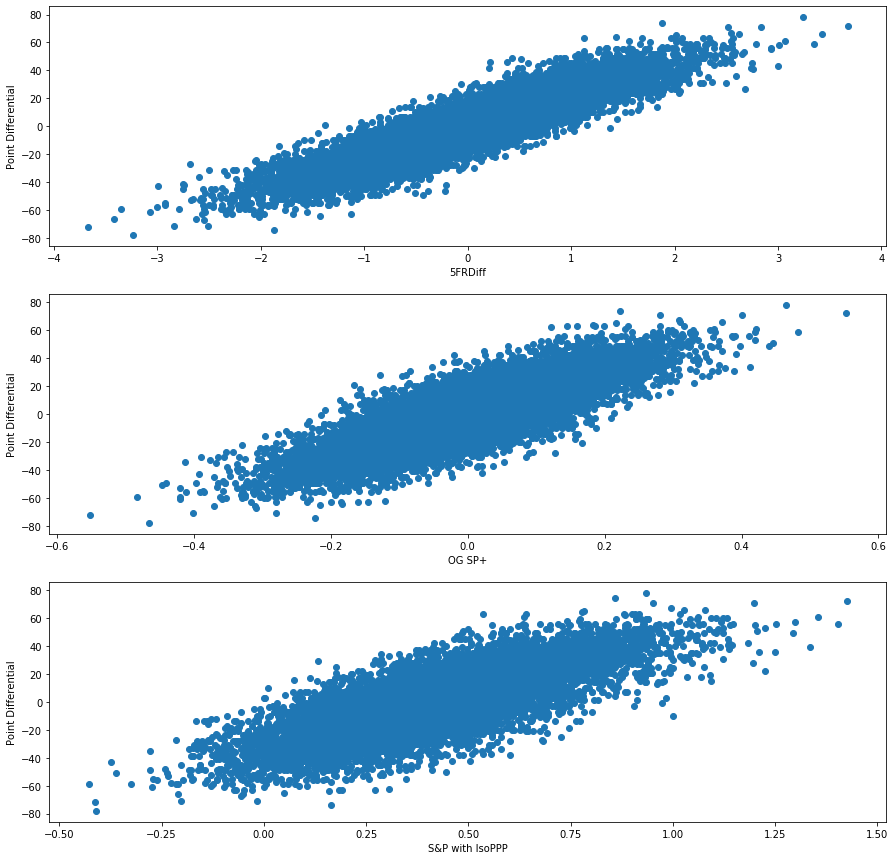

In [17]:
f, axes = plt.subplots(3, figsize=(15, 15))#plt.subplots(len(inputs), figsize=(20, len(inputs) * 8))

# for i in range(len(inputs)):
#     inpt = inputs[i]
axes[0].scatter(stored_game_boxes[f"5FRDiff"], stored_game_boxes.PtsDiff);
axes[0].set_xlabel("5FRDiff")
axes[0].set_ylabel("Point Differential");

axes[1].scatter(0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"], stored_game_boxes.PtsDiff);
axes[1].set_xlabel("OG SP+")
axes[1].set_ylabel("Point Differential");

axes[2].scatter(stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"], stored_game_boxes.PtsDiff);
axes[2].set_xlabel("S&P with IsoPPP")
axes[2].set_ylabel("Point Differential");

In [18]:
sp_isoppp = 0.86*stored_game_boxes[f"OffSRDiff"] + 0.14*stored_game_boxes[f"IsoPPPDiff"]
sp_eqppp = stored_game_boxes[f"OffSRDiff"] + stored_game_boxes[f"AvgEqPPP"]
correl = pd.DataFrame(data={"OGS&PDiff":sp_eqppp,"S&PIsoPPPDiff":sp_isoppp,"PtsDiff":stored_game_boxes.PtsDiff})
correl.corr()

,OGS&PDiff,S&PIsoPPPDiff,PtsDiff
OGS&PDiff,1.000000,0.911982,0.759438
S&PIsoPPPDiff,0.911982,1.000000,0.816783
PtsDiff,0.759438,0.816783,1.000000


In [19]:
# Eliminate outliers
from scipy import stats
import numpy as np
stored_game_boxes['5fr_z_score'] = np.abs(stats.zscore(stored_game_boxes['5FRDiff']))
stored_game_boxes['pts_z_score'] = np.abs(stats.zscore(stored_game_boxes.PtsDiff))
stored_game_boxes.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813,1.037219,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037219,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104,0.474276,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104,0.474276,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776,0.583586,0.499553


In [20]:
outliers = stored_game_boxes[(stored_game_boxes['5fr_z_score'] >= 3.2) | (stored_game_boxes['pts_z_score'] >= 3)]
basis = stored_game_boxes[(stored_game_boxes['5fr_z_score'] < 3.2) & (stored_game_boxes['pts_z_score'] < 3.)]
msk = (np.random.rand(len(basis)) < 0.80)
train_data = basis[msk]
test_data = basis[~msk]

In [21]:
# outliers

In [22]:
train_data.head()

,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,5fr_z_score,pts_z_score
0,UCF,2012,322432006,56.0,42.0,0.796214,0.492537,0.074627,6.029851,0.683285,...,0.007186,0.388889,0.000000,0.200000,0.200000,0.000000,5.453906,0.907813,1.037219,1.907384
1,Akron,2012,322432006,14.0,-42.0,0.203786,0.382716,0.061728,4.370370,0.641765,...,-0.007186,-0.388889,0.000000,-0.200000,-0.200000,0.000000,4.546094,-0.907813,1.037219,1.907384
2,South Carolina,2012,322430238,17.0,4.0,0.518995,0.435484,0.080645,5.129032,0.749257,...,0.036359,-0.333333,-0.333333,-0.250000,-0.250000,0.333333,5.207552,0.415104,0.474276,0.181656
3,Vanderbilt,2012,322430238,13.0,-4.0,0.481005,0.271186,0.152542,5.813559,1.171577,...,-0.036359,0.333333,0.333333,0.250000,0.250000,-0.333333,4.792448,-0.415104,0.474276,0.181656
4,Eastern Michigan,2012,322432050,26.0,-11.0,0.020080,0.447761,0.134328,6.119403,1.072704,...,0.010417,-0.416667,-0.541667,-0.095238,-0.095238,-0.750000,4.744612,-0.510776,0.583586,0.499553


In [23]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import check_array
from sklearn.metrics import mean_absolute_error, median_absolute_error, r2_score
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    if (y_true.sum() > 0):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    else:
        return "???"
    

inputDiffs = []
for inpt in inputs:
    inputDiffs.append(f"{inpt}Diff")

In [24]:
model = LinearRegression().fit(train_data['5FRDiff'][:, np.newaxis], train_data.PtsDiff)

print(f'Linear Regression: y = {model.coef_[0]:.5f}x + {model.intercept_:.5f}')

preds = model.predict(test_data['5FRDiff'][:, np.newaxis])

print(f"Mean Pred Score: {preds.mean()}")
print(f"Pred Std Dev: {preds.std()}")

# MAPE is not a trustworthy measurement when the mean's going to be near zero
# mape = mean_absolute_percentage_error(test_data["PtsDiff"][:, np.newaxis], preds)
# print(f"MAPE: {mape}%")

MAE = mean_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mean Abs Error: {MAE}")

MdnAE = median_absolute_error(test_data["PtsDiff"][:, np.newaxis], preds)
print(f"Mdn Abs Error: {MdnAE}")

corr_matx = {
    'ActPtsDiff' : test_data['PtsDiff'],
}
for inptDf in inputDiffs:
    corr_matx[inptDf] = test_data[inptDf]
corr_matx['5FR'] = test_data['5FR']
corr_matx['5FRDiff'] = test_data['5FRDiff']
corr_matx['PredPtsDiff'] = preds
test = pd.DataFrame(corr_matx)

print(f'R-squared: {r2_score(test_data["PtsDiff"][:,np.newaxis], preds)}\n')
    
test.corr()

Linear Regression: y = 22.73555x + -0.05195
Mean Pred Score: -0.28263957566306785
Pred Std Dev: 19.715410452844505
Mean Abs Error: 7.571223143883291
Mdn Abs Error: 6.229166207163685
R-squared: 0.802720018786774



,ActPtsDiff,OffSRDiff,OffERDiff,FPDiff,OppRateDiff,OppEffDiff,OppPPDDiff,PPDDiff,OppSRDiff,YPPDiff,...,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.768548,0.575340,0.498202,0.801468,0.593170,0.587202,0.982757,0.515894,0.781139,...,0.543434,0.445280,0.259765,0.180609,0.070637,0.136765,0.180324,0.896110,0.896110,0.896110
OffSRDiff,0.768548,1.000000,0.490313,0.305666,0.708085,0.389184,0.424378,0.769437,0.734855,0.722847,...,0.538488,0.403866,0.206651,0.123947,-0.006582,0.052375,0.073227,0.919578,0.919578,0.919578
OffERDiff,0.575340,0.490313,1.000000,0.162963,0.510621,0.306648,0.336847,0.567751,0.354760,0.801380,...,0.188340,0.199327,0.164793,0.073602,0.006155,0.043563,0.060832,0.528193,0.528193,0.528193
FPDiff,0.498202,0.305666,0.162963,1.000000,0.606954,0.107271,0.098931,0.473653,0.060371,0.240910,...,0.282757,0.241749,0.322525,0.276791,0.227502,0.254868,0.173397,0.574606,0.574606,0.574606
OppRateDiff,0.801468,0.708085,0.510621,0.606954,1.000000,0.216912,0.216473,0.801313,0.282694,0.679573,...,0.514395,0.413585,0.251637,0.186590,0.052998,0.123345,0.231843,0.832909,0.832909,0.832909
OppEffDiff,0.593170,0.389184,0.306648,0.107271,0.216912,1.000000,0.735119,0.591433,0.490977,0.429917,...,0.287700,0.238764,0.129478,0.062364,0.034061,0.055516,0.364339,0.480281,0.480281,0.480281
OppPPDDiff,0.587202,0.424378,0.336847,0.098931,0.216473,0.735119,1.000000,0.596907,0.542747,0.467053,...,0.317730,0.261856,0.109772,0.081721,0.028026,0.051772,0.066792,0.544740,0.544740,0.544740
PPDDiff,0.982757,0.769437,0.567751,0.473653,0.801313,0.591433,0.596907,1.000000,0.515286,0.773387,...,0.544263,0.442278,0.258007,0.174483,0.066349,0.142051,0.168127,0.891510,0.891510,0.891510
OppSRDiff,0.515894,0.734855,0.354760,0.060371,0.282694,0.490977,0.542747,0.515286,1.000000,0.531304,...,0.338796,0.251760,0.133976,0.077250,-0.016894,0.002925,-0.069955,0.655300,0.655300,0.655300
YPPDiff,0.781139,0.722847,0.801380,0.240910,0.679573,0.429917,0.467053,0.773387,0.531304,1.000000,...,0.442515,0.397859,0.191941,0.110613,-0.014512,0.038101,0.077717,0.759307,0.759307,0.759307


In [25]:
# Evaluating each factor
matx_factors = pd.DataFrame(data={
    'ActPtsDiff' : test_data['PtsDiff'],
    'ActPts' : test_data['Pts']
})
matx_factors['Eff'] = test_data.apply(lambda x: 0.35 * create_eff_index(x), axis=1)
matx_factors['Expl'] = test_data.apply(lambda x: 0.30 * create_expl_index(x), axis=1) 
matx_factors['FinDrv'] = test_data.apply(lambda x: 0.15 * create_finish_drive_index(x), axis=1) 
matx_factors['FldPos'] = test_data.apply(lambda x: 0.10 * create_fp_index(x), axis=1) 
matx_factors['Trnovr'] = test_data.apply(lambda x: 0.10 * create_turnover_index(x), axis=1) 
matx_factors['5FR'] = test_data['5FR']
matx_factors['5FRDiff'] = test_data['5FRDiff']
matx_factors['PredPtsDiff'] = preds
matx_factors.corr()

,ActPtsDiff,ActPts,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff,PredPtsDiff
ActPtsDiff,1.000000,0.752769,0.768548,0.729864,0.896527,0.498202,0.476964,0.896110,0.896110,0.896110
ActPts,0.752769,1.000000,0.576352,0.567124,0.667728,0.378789,0.367114,0.673934,0.673934,0.673934
Eff,0.768548,0.576352,1.000000,0.649844,0.800232,0.305666,0.251798,0.919578,0.919578,0.919578
Expl,0.729864,0.567124,0.649844,1.000000,0.702287,0.235328,0.229662,0.703302,0.703302,0.703302
FinDrv,0.896527,0.667728,0.800232,0.702287,1.000000,0.432855,0.413602,0.922168,0.922168,0.922168
FldPos,0.498202,0.378789,0.305666,0.235328,0.432855,1.000000,0.381187,0.574606,0.574606,0.574606
Trnovr,0.476964,0.367114,0.251798,0.229662,0.413602,0.381187,1.000000,0.469606,0.469606,0.469606
5FR,0.896110,0.673934,0.919578,0.703302,0.922168,0.574606,0.469606,1.000000,1.000000,1.000000
5FRDiff,0.896110,0.673934,0.919578,0.703302,0.922168,0.574606,0.469606,1.000000,1.000000,1.000000
PredPtsDiff,0.896110,0.673934,0.919578,0.703302,0.922168,0.574606,0.469606,1.000000,1.000000,1.000000


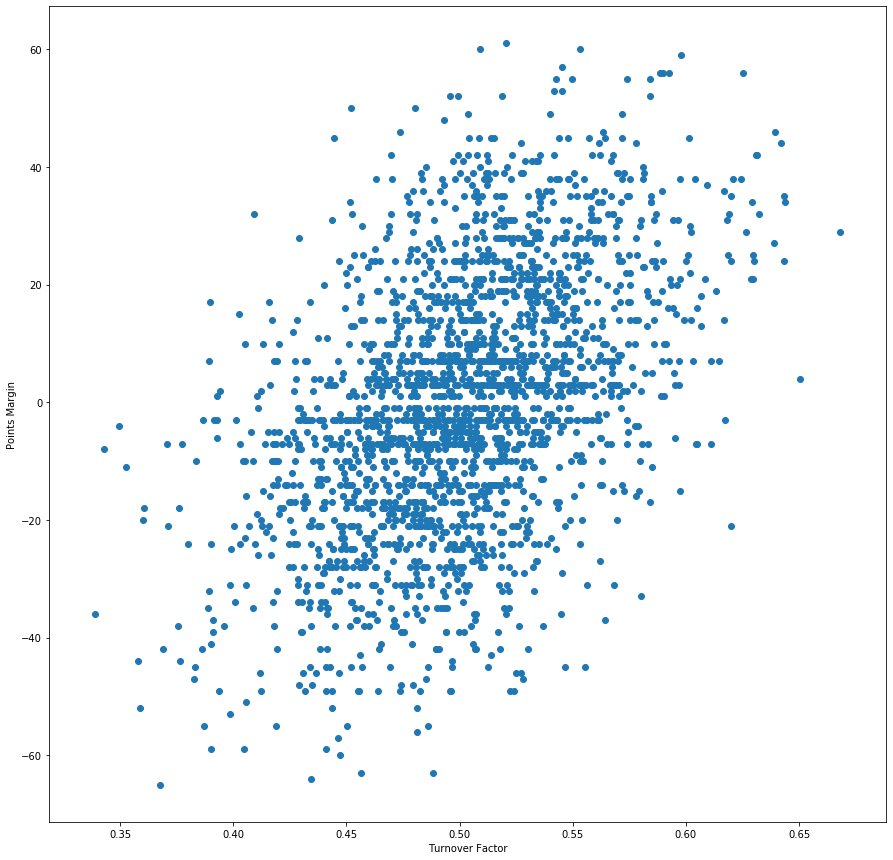

In [26]:
f, ax = plt.subplots(1, figsize=(15, 15))

ax.scatter(matx_factors["Trnovr"], matx_factors.ActPtsDiff);
ax.set_xlabel("Turnover Factor")
ax.set_ylabel("Points Margin");

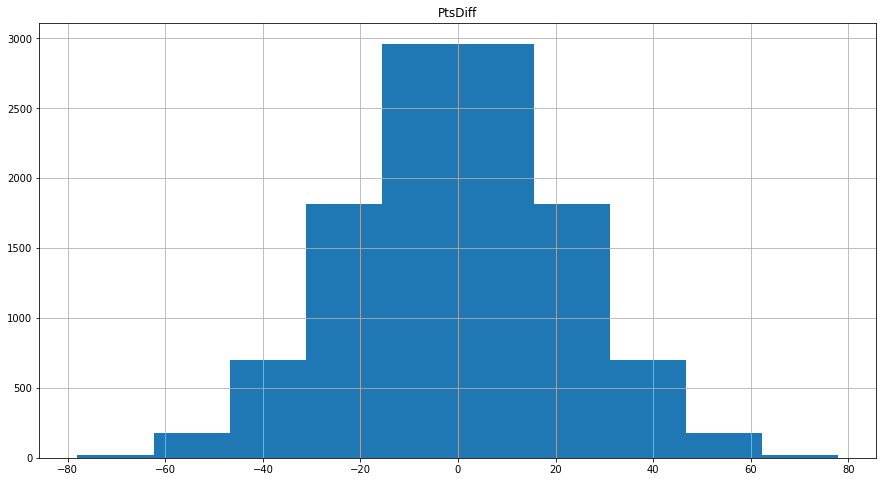

In [27]:
stored_game_boxes.hist(column='PtsDiff', figsize=(15,8));

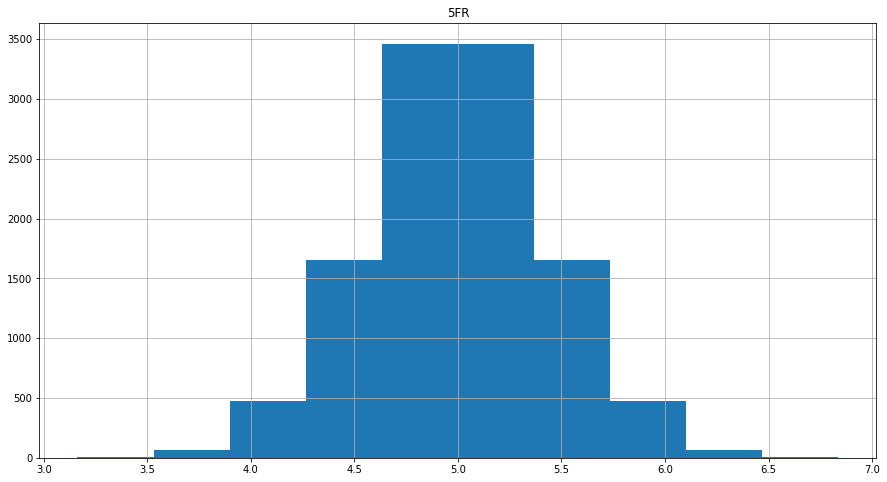

In [28]:
stored_game_boxes.hist(column='5FR', figsize=(15,8));

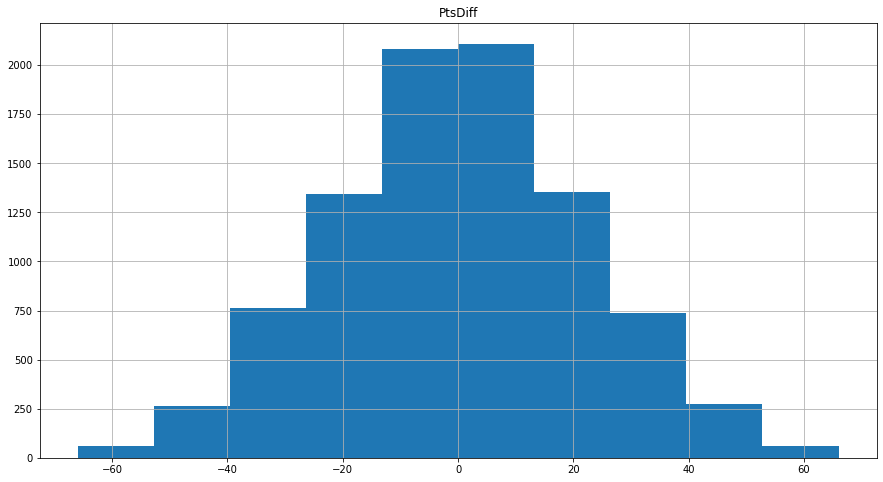

In [29]:
train_data.hist(column='PtsDiff', figsize=(15,8));

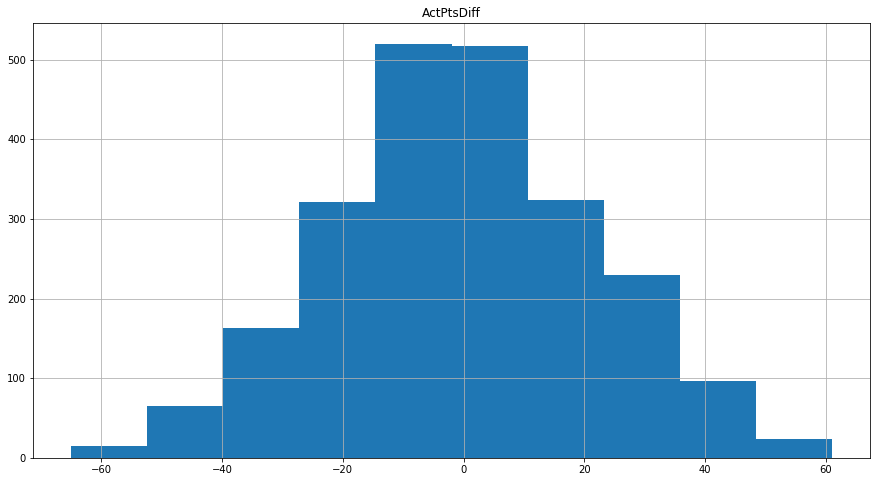

In [30]:
test.hist(column='ActPtsDiff', figsize=(15,8));

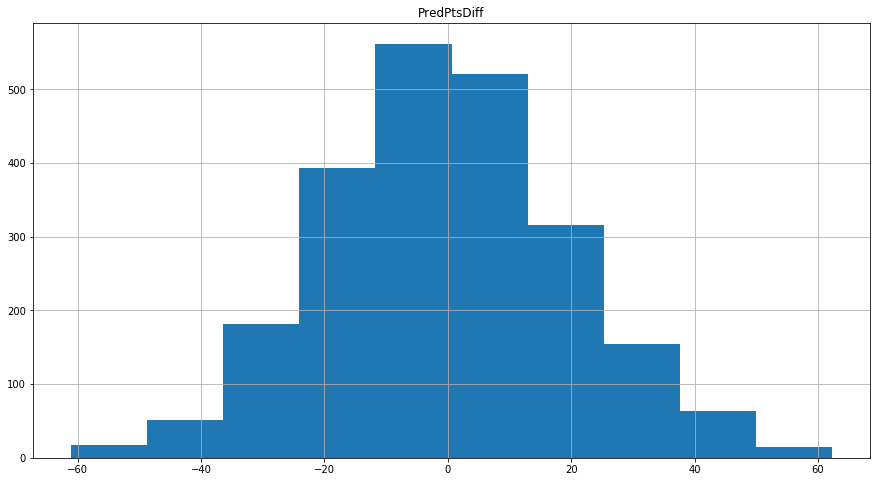

In [31]:
test.hist(column='PredPtsDiff', figsize=(15,8));

In [32]:
def generate_win_prob(game_id, year):
    sample_box = calculate_box_score(game_id, year)
    mu = preds.mean()
    std = preds.std()

    max_box_row = sample_box[sample_box['PtsDiff'] == max(sample_box['PtsDiff'])]
    parts = sample_box.Team.tolist()
    print(f"Game: {parts[0]} @ {parts[1]}")
    print(f"Actual Winner: {stringify_entry(max_box_row.Team)}")
    act_MOV = stringify_entry(max_box_row.PtsDiff)
    print(f"MOV: {stringify_entry(max_box_row.Team)} by {act_MOV}")
#     print(f"5FRDiff for {stringify_entry(max_box_row.Team)}: {stringify_entry(max_box_row['5FRDiff'])}")
    proj_point_diff = model.predict(max_box_row['5FRDiff'][:,np.newaxis])[0]
    print(f"Proj MOV: {stringify_entry(max_box_row.Team)} by {round(proj_point_diff)} (exact value: {proj_point_diff})")
    z = (proj_point_diff - mu) / std
    print(f"Z score: {z}")
    win_prob = stats.norm.cdf(z)
    print(f"Win Prob for {stringify_entry(max_box_row.Team)}: {(100 * win_prob):.2f}%")
    print("---")
    
    return [win_prob, act_MOV]

In [33]:
generate_win_prob(401013183, 2018)  # 2018 UVA at VT for sample (this should be in the dataset, so not ideal)
calculate_box_score(401013183, 2018)

Game: Virginia @ Virginia Tech
Actual Winner: Virginia Tech
MOV: Virginia Tech by 3.0
Proj MOV: Virginia Tech by -3.0 (exact value: -3.260764716178737)
Z score: -0.15105570069863752
Win Prob for Virginia Tech: 44.00%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia,2018,401013183,31.0,-3.0,0.875665,0.396825,0.111111,6.507937,0.930578,...,0.124959,-0.040309,-0.002715,0.0,0.166667,0.119048,0.119048,0.333333,5.070568,0.141137
1,Virginia Tech,2018,401013183,34.0,3.0,0.124335,0.368421,0.078947,5.513158,0.805619,...,-0.124959,0.040309,0.002715,0.0,-0.166667,-0.119048,-0.119048,-0.333333,4.929432,-0.141137


In [34]:
generate_win_prob(401112488, 2019)  # 2019 GT at MIA
calculate_box_score(401112488, 2019)

Game: Georgia Tech @ Miami
Actual Winner: Georgia Tech
MOV: Georgia Tech by 7.0
Proj MOV: Georgia Tech by -11.0 (exact value: -11.396875010977555)
Z score: -0.5637334034661675
Win Prob for Georgia Tech: 28.65%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia Tech,2019,401112488,28.0,7.0,0.065752,0.396825,0.111111,5.460317,0.894136,...,-0.121075,0.018689,0.000768,0.0,0.0,0.166667,0.166667,0.0,4.750502,-0.498995
1,Miami,2019,401112488,21.0,-7.0,0.934248,0.370968,0.112903,5.790323,1.015211,...,0.121075,-0.018689,-0.000768,0.0,0.0,-0.166667,-0.166667,0.0,5.249498,0.498995


In [35]:
generate_win_prob(401112513, 2019)  # 2019 NCST at GT
calculate_box_score(401112513, 2019)

Game: NC State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 2.0
Proj MOV: Georgia Tech by -1.0 (exact value: -0.6255792240444527)
Z score: -0.017394497020573368
Win Prob for Georgia Tech: 49.31%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,NC State,2019,401112513,26.0,-2.0,0.156447,0.487500,0.150000,5.712500,0.704891,...,-0.300725,0.012719,0.0,-0.133333,0.066667,0.0,0.0,1.0,5.012615,0.025231
1,Georgia Tech,2019,401112513,28.0,2.0,0.843553,0.473684,0.140351,7.035088,1.005617,...,0.300725,-0.012719,0.0,0.133333,-0.066667,0.0,0.0,-1.0,4.987385,-0.025231


In [36]:
generate_win_prob(401110863, 2019)  # 2019 Ole Miss at MSST
calculate_box_score(401110863, 2019)

Game: Ole Miss @ Mississippi State
Actual Winner: Mississippi State
MOV: Mississippi State by 1.0
Proj MOV: Mississippi State by 3.0 (exact value: 3.483121059922365)
Z score: 0.19100594657120698
Win Prob for Mississippi State: 57.57%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Ole Miss,2019,401110863,20.0,-1.0,0.384124,0.422535,0.070423,5.563380,0.880173,...,0.092249,0.000243,-0.004614,-0.666667,-0.333333,0.0,0.0,0,4.922257,-0.155486
1,Mississippi State,2019,401110863,21.0,1.0,0.615876,0.413793,0.137931,5.482759,0.787924,...,-0.092249,-0.000243,0.004614,0.666667,0.333333,0.0,0.0,0,5.077743,0.155486


In [37]:
generate_win_prob(401012356, 2018) # 2018 LSU vs TAMU  (this should be in the dataset, so not ideal)
calculate_box_score(401012356, 2018)

Game: LSU @ Texas A&M
Actual Winner: Texas A&M
MOV: Texas A&M by 2.0
Proj MOV: Texas A&M by -5.0 (exact value: -5.0521194716978295)
Z score: -0.24191633785370312
Win Prob for Texas A&M: 40.44%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,LSU,2018,401012356,72.0,-2.0,0.321374,0.466667,0.088889,5.511111,0.682602,...,-0.349878,0.001282,-0.047436,0.2,0.2,-0.25,-0.25,-0.25,5.109964,0.219927
1,Texas A&M,2018,401012356,74.0,2.0,0.678626,0.423077,0.105769,4.634615,1.032480,...,0.349878,-0.001282,0.047436,-0.2,-0.2,0.25,0.25,0.25,4.890036,-0.219927


In [38]:
# Team Ratings by Avg Win Prob??
def calculate_avg_win_prob(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict([[tester['5FRDiff'].mean()]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
#     print(f"Avg Win Prob for {team}: {(100 * stats.norm.cdf(z)):.2f}%")
    win_prob = stats.norm.cdf(z)
    return win_prob

consider_teams = teams[teams.conference.isin(fbs)].school.tolist()
team_wp_frame = pd.DataFrame({"team":consider_teams})
team_wp_frame['avg_win_prob'] = team_wp_frame.apply(lambda x: calculate_avg_win_prob(x.team, 2019), axis=1)
# for team in team_list:
#     team_wp_frame = team_wp_frame.append(pd.DataFrame({
#         'team':[team],
#         'avg_win_prob':[calculate_avg_win_prob(team, 2019)]
#     }))
team_wp_frame['games'] = team_wp_frame.apply(lambda x: len(games[(games.season == 2019) & ((games.home_team == x.team) | (games.away_team == x.team))]), axis=1)
team_wp_frame['proj_wins'] = round(team_wp_frame.avg_win_prob * team_wp_frame.games)
team_wp_frame['proj_losses'] = team_wp_frame.games - team_wp_frame['proj_wins']
team_wp_frame = team_wp_frame.sort_values(by=['avg_win_prob','games'], ascending=False)
team_wp_frame.index = range(1,len(team_wp_frame.team)+1)
team_wp_frame

,team,avg_win_prob,games,proj_wins,proj_losses
1,Ohio State,0.943689,13,12.0,1.0
2,Clemson,0.937202,13,12.0,1.0
3,Alabama,0.913903,12,11.0,1.0
4,LSU,0.912384,13,12.0,1.0
5,Wisconsin,0.876836,13,11.0,2.0
6,Utah,0.847857,13,11.0,2.0
7,Oklahoma,0.830825,13,11.0,2.0
8,Oregon,0.817594,13,11.0,2.0
9,Appalachian State,0.802659,13,10.0,3.0
10,Georgia,0.794763,13,10.0,3.0


In [39]:
# Team Ratings by Avg Win Prob??
def calculate_z(item, mu, std):
    return (item - mu) / std

def calculate_second_order_wins(team, year):
#     print(team)
    tester = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == year)]
    if (len(tester) == 0):
        return 0
    pred = model.predict(tester['5FRDiff'][:,np.newaxis])
    mu = preds.mean()
    std = preds.std()
    zs = np.vectorize(calculate_z)(pred, mu, std)
    probs = stats.norm.cdf(zs)
    return probs.sum()

team_second_order_frame = pd.DataFrame({"team":consider_teams})
team_second_order_frame["second_order_wins"] = team_second_order_frame.apply(lambda x: calculate_second_order_wins(x.team, 2019),axis=1)
team_second_order_frame["second_order_losses"] = team_second_order_frame.apply(lambda x: len(games[((games.home_team == x.team) | (games.away_team == x.team)) & (games.season == 2019)]) - x.second_order_wins,axis=1)
team_second_order_frame.sort_values(by=['second_order_wins'], ascending=False)

,team,second_order_wins,second_order_losses
77,Ohio State,11.547437,1.452563
21,Clemson,10.636010,2.363990
53,LSU,10.424722,2.575278
128,Wisconsin,9.677369,3.322631
2,Alabama,9.334157,2.665843
115,Utah,9.208839,3.791161
78,Oklahoma,9.119805,3.880195
3,Appalachian State,8.802642,4.197358
82,Oregon,8.795465,4.204535
34,Georgia,8.582297,4.417703


In [40]:
# Matchup Predictor?
grouped_by_year = stored_game_boxes.copy().groupby(['Team','Season'])
ratings = grouped_by_year.apply(lambda x: x['5FR'].mean())
team_fr_year = ratings.reset_index()
team_fr_year.columns = ["Team",'Season','5FR']
team_fr_year

tmp = team_fr_year.groupby('Season').apply(lambda x: x.sort_values(by='5FR', ascending=False)).reset_index(drop=True)
team_strength = pd.DataFrame()
for yr in range(2012, 2020):
    retrieve = tmp[tmp.Season == yr].copy()
    retrieve['Rank'] = range(1, len(retrieve)+1)
    team_strength = team_strength.append(retrieve)
team_strength

,Team,Season,5FR,Rank
0,Alabama,2012,5.557889,1
1,Florida State,2012,5.454605,2
2,BYU,2012,5.335653,3
3,Arizona State,2012,5.333539,4
4,Oklahoma,2012,5.331083,5
5,Fresno State,2012,5.309021,6
6,Georgia,2012,5.304040,7
7,Notre Dame,2012,5.289858,8
8,Utah State,2012,5.267835,9
9,Kansas State,2012,5.266560,10


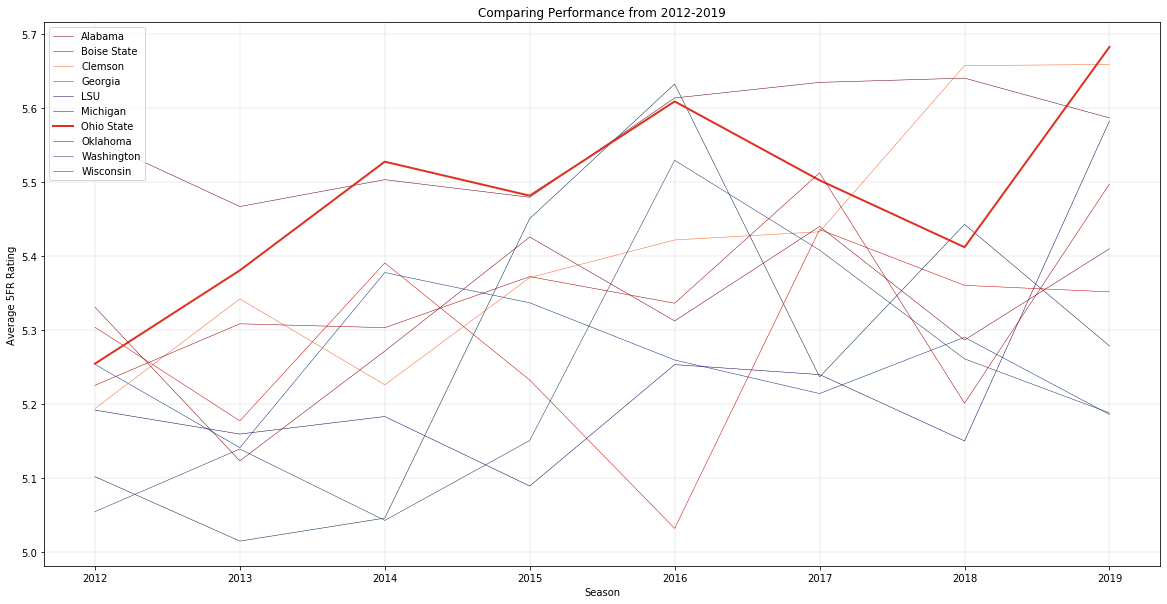

In [113]:
# Graph team progression
def retrieve_ratings_chart(team, highlight_team = None):
    fig, ax = plt.subplots(1, figsize=(20,10))
    ax.grid(linestyle='-', linewidth=0.25)
    ax.set_xlabel('Season');
    ax.set_ylabel('Average 5FR Rating')
    if (isinstance(team, str)):
        school_ratings = team_strength[team_strength.Team == team]
        team_info = teams[teams.school == team]
    else:
        school_ratings = team_strength[team_strength.Team.isin(team)]
        team_info = teams[teams.school.isin(team)]
        
    opacity = 1.0
    for idx, item in team_info.iterrows():
        if ((item.school == highlight_team) & (highlight_team != None)):
            opacity = 2.0
        elif ((item.school != highlight_team) & (highlight_team != None)):
            opacity = 0.5
        else:
            opacity = 1.0
        ax.plot(school_ratings[school_ratings.Team == item.school].Season, school_ratings[school_ratings.Team == item.school]['5FR'], color=item.color,label=item.school, linewidth=opacity)
    
#     ax.plot(school_ratings.Season, np.full(len(school_ratings.Season), 5), color='y',label="National Average")
    ax.set_title(f"Comparing Performance from {min(school_ratings.Season)}-{max(school_ratings.Season)}")
    ax.legend()
    return ax
retrieve_ratings_chart(["Alabama","Ohio State","Clemson","Wisconsin","Oklahoma","Georgia","Michigan","Boise State","LSU","Washington"], highlight_team = "Ohio State");

In [72]:
# Rank teams by avg strength rating from 2012-19
strength_ranks = team_strength.copy().groupby(['Team']).apply(lambda x: x['5FR'].mean()).sort_values(ascending=False)
strength_ranks = strength_ranks.reset_index()
strength_ranks.columns = ["Team",'Avg5FR']
strength_ranks

,Team,Avg5FR
0,Alabama,5.560512
1,Ohio State,5.481456
2,Clemson,5.413149
3,Wisconsin,5.344711
4,Oklahoma,5.325188
5,Georgia,5.285696
6,Michigan,5.275654
7,Boise State,5.257562
8,LSU,5.231349
9,Washington,5.221882


In [41]:
def filter_opponents(box, team):
    return box[box.Team != team].Team.tolist()[0]

# grouped_by_team = stored_game_boxes.groupby(['GameID'])
opponent_game_ids = pd.DataFrame()
for team in team_list:
    for yr in range(2012, 2020):
        team_games = stored_game_boxes[(stored_game_boxes.Team == team) & (stored_game_boxes.Season == yr)].GameID.to_list()
        for idx, item in enumerate(team_games, start=1):
            box = stored_game_boxes[stored_game_boxes.GameID == item]
            opp = filter_opponents(box, team)
            opponent_game_ids = opponent_game_ids.append({'GameID' : item, 'Team':team,'Opponent':opp,'Season':stringify_entry(box.Season), 'Week': idx}, ignore_index=True)
opponent_game_ids

,GameID,Opponent,Season,Team,Week
0,322520130.0,Michigan,2012.0,Air Force,1.0
1,322662439.0,UNLV,2012.0,Air Force,2.0
2,322732005.0,Colorado State,2012.0,Air Force,3.0
3,322802005.0,Navy,2012.0,Air Force,4.0
4,322872751.0,Wyoming,2012.0,Air Force,5.0
5,322942005.0,New Mexico,2012.0,Air Force,6.0
6,323002005.0,Nevada,2012.0,Air Force,7.0
7,323080349.0,Army,2012.0,Air Force,8.0
8,323150021.0,San Diego State,2012.0,Air Force,9.0
9,323212005.0,Hawai'i,2012.0,Air Force,10.0


In [42]:
def predict_matchup(team1, team2, year, week = -1, games_to_consider = 4):
    # Start with some default values
    natl_avg = team_strength[(team_strength.Season == year)]['5FR'].mean()
    fcs = team_strength[(team_strength.Season == year)].quantile(.02)['5FR'] # assume any/all FCS team is only as good as the bottom 2% of FBS
    if (games_to_consider <= 0):
        games_to_consider = 16 # consider all games
    
    if (week <= 0):
        week = 16 # consider all weeks
    
    # Generate comparison attributes for team 1
    team1_avg_ffr = grouped_by_year.get_group((team1, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team1, year) in grouped_by_year.groups) else natl_avg
    team1_sos = natl_avg
    team1_opps = opponent_game_ids[(opponent_game_ids.Team == team1) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    team1_record = teams[(teams.school == team1)]
    team1_conf = stringify_entry(team1_record.conference)
    team1_conf_teams = teams[teams.conference == team1_conf].school.to_list()

    if ~(team1_record.conference.isin(fbs).any()):
        team1_avg_ffr = fcs
        team1_sos = fcs
        team1_conf_sos = fcs
        team1_subdiv_sos = fcs
    else:
        team1_sos = team_strength[(team_strength.Team.isin(team1_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team1_conf_sos = team_strength[(team_strength.Team.isin(team1_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team1_p5 = (stringify_entry(team1_record.conference) in p5)
        team1_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team1_p5)].school.to_list()
        team1_subdiv_sos = team_strength[(team_strength.Team.isin(team1_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()

    # Generate comparison attributes for team 2
    team2_avg_ffr = grouped_by_year.get_group((team2, year))[:week]['5FR'].tail(games_to_consider).mean() if ((team2, year) in grouped_by_year.groups) else natl_avg
    team2_sos = natl_avg
    team2_record = teams[(teams.school == team2)]
    team2_conf = stringify_entry(team2_record.conference)
    team2_conf_teams = teams[teams.conference == team2_conf].school.to_list()
    team2_opps = opponent_game_ids[(opponent_game_ids.Team == team2) & (opponent_game_ids.Week < week)][:week].Opponent.to_list()
    if ~(team2_record.conference.isin(fbs).any()):
        team2_avg_ffr = fcs
        team2_sos = fcs
        team2_conf_sos = fcs
        team2_subdiv_sos = fcs
    else:
        team2_sos = team_strength[(team_strength.Team.isin(team2_opps)) & (team_strength.Season == year)]['5FR'].mean()
        team2_conf_sos = team_strength[(team_strength.Team.isin(team2_conf_teams)) & (team_strength.Season == year)]['5FR'].mean()
        team2_p5 = (stringify_entry(team2_record.conference) in p5)
        team2_subdiv_members = teams[teams.conference.isin(fbs) & (teams.conference.isin(p5) == team2_p5)].school.to_list()
        team2_subdiv_sos = team_strength[(team_strength.Team.isin(team2_subdiv_members)) & (team_strength.Season == year)]['5FR'].mean()
    
    # adjust based on fcs vs fbs AND overall strength of schedule
    if (team2_sos < team1_sos):
        team2_avg_ffr *= (team2_sos / team1_sos)
    elif (team2_sos > team1_sos):
        team1_avg_ffr *= (team1_sos / team2_sos)
        
    # adjust based on p5 vs g5
    if (team2_subdiv_sos < team1_subdiv_sos):
        team2_avg_ffr *= (team2_subdiv_sos / team1_subdiv_sos)
    elif (team2_subdiv_sos > team1_subdiv_sos):
        team1_avg_ffr *= (team1_subdiv_sos / team2_subdiv_sos)
        
    # adjust based on conference SoS
    if (team2_conf_sos < team1_conf_sos):
        team2_avg_ffr *= (team2_conf_sos / team1_conf_sos)
    elif (team2_conf_sos > team1_conf_sos):
        team1_avg_ffr *= (team1_conf_sos / team2_conf_sos)
    
    ffr_diff = team1_avg_ffr - team2_avg_ffr # assumes team_1 is home
    pred = model.predict([[ffr_diff]])
    mu = preds.mean()
    std = preds.std()
    z = (pred[0] - mu) / std
    win_prob = stats.norm.cdf(z)
    return [win_prob, pred[0]]

predict_matchup('Georgia Tech', 'Clemson', 2019, 0, -1)

[0.1500333498710975, -20.713529471348203]

In [43]:
team_triples = [
#     ['Buffalo', 'Charlotte', 7], # Buff 31, Char 9
#     ['Utah State', 'Kent State', 7], # Kent 51, Utah 41
#     ['San Diego State', 'Central Michigan', 3.5], # SDSU 48, CMU 11
#     ['Georgia Southern','Liberty', 4.5], # Lib 23, GASO 16
#     ['SMU','Florida Atlantic', 7], # FAU 52, SMU 28
#     ['Florida International','Arkansas State', 1], # ArkSt 34, FIU 28
#     ['Washington', 'Boise State', 3.5], # Wash 38, Boise 7
#     ['Appalachian State', 'UAB', 17], # App 31, UAB 17
#     ['UCF','Marshall',15], # UCF 48, Marshall 25
#     ['BYU',"Hawai'i",2], # Hawaii 38, BYU 34
#    ----- 7-3 SU / 5-5 ATS ------
#     ['Miami','Louisiana Tech',6], # LaTech 14, Miami 0
#     ['Pittsburgh','Eastern Michigan',11], # Pitt 34, EMU 30
#    ----- 8-4 SU / 6-6 ATS ------ 
#     ['North Carolina','Temple',5], # UNC 55, Temple 13
#     ['Michigan State','Wake Forest',3.5], # MichSt 27, Wake 21
#     ['Texas A&M', 'Oklahoma State', 7], # TAMU 24, OKST 21
#     ['Iowa', 'USC', 2.5], # Iowa 48, USC 24
#     ['Air Force', 'Washington State', 3], # AFA 31, Wazzu 21
#    ----- 12-5 SU / 9-8 ATS ------ 
#     ['Penn State','Memphis',7], # Cotton Bowl - PennSt 53, Memphis 39
#     ['Notre Dame', 'Iowa State', 4], # ND 33, IAST 9
#    ----- 13-6 SU / 10-9 ATS ------ 
#     ['LSU','Oklahoma',11], # CFP Semifinal: Peach Bowl: LSU 63, OU 28
#    ----- 14-6 SU / 10-10 ATS ------ 
#     ['Clemson','Ohio State',2.5], # CFP Semifinal: Fiesta Bowl: CLEM 29, OhioSt 23
#    ----- 15-6 SU / 11-10 ATS ------ 
#     ['Western Kentucky', 'Western Michigan', 3.5], # WKU 23, WMU 20
#     ['Mississippi State', 'Louisville', 4], # LOU 38, MSST 28
#     ['California', 'Illinois', 6.5], # Cal 35, Ill 20
#    ----- 17-7 SU / 12-12 ATS ------     
#     ['Florida','Virginia',14], # Orange Bowl # UF 36, UVA 28
#    ----- 18-7 SU / 13-12 ATS ------     
#     ['Virginia Tech', 'Kentucky', 3], # Kentucky 37, VT 30
#    ----- 18-8 SU / 13-13 ATS ------    
#     ['Arizona State', 'Florida State', 4],
#    ----- 19-8 SU / 14-13 ATS ------  
#     ['Navy', 'Kansas State', 2],
#    ----- 20-8 SU / 15-13 ATS ------  
#     ['Wyoming', 'Georgia State', 7],
#    ----- 21-8 SU / 15-14 ATS ------  
#     ['Utah', 'Texas', 7],
#    ----- 21-9 SU / 16-14 ATS ------     
    ['Auburn', 'Minnesota', 7.5],
    ['Alabama', 'Michigan', 7],
    ['Wisconsin','Oregon',2.5], # Rose Bowl
    ['Georgia','Baylor',7.5], # Sugar Bowl
    
    ['Cincinnati', 'Boston College',7],
    ['Tennessee', 'Indiana', 1.5],
    
    ['Ohio', 'Nevada', 7.5],
    
    ['Tulane', 'Southern Mississippi', 7],
    
    ['Louisiana', 'Miami (OH)', 14]
]

bets = pd.DataFrame()

for data in team_triples:
    team1 = data[0]
    team2 = data[1]
    spread = data[2] # team 1 is always favorite
    predictor = predict_matchup(team1, team2, 2019)
    bets = bets.append(pd.DataFrame({
        "favorite": [team1],
        "opponent" : [team2],
        "spread" : [spread],
        "proj_MOV" : [predictor[1]],
        "proj_win_prob" : [predictor[0]],
        "proj_cover_status" : [predictor[1] > spread],
        "ml_pick": [team1 if (predictor[1] > 0) else team2],
        "ats_pick": [team1 if (predictor[1] > spread) else team2]
    }))
    
bets #.sort_values(by=['proj_cover_status','proj_MOV'], ascending=False)

,favorite,opponent,spread,proj_MOV,proj_win_prob,proj_cover_status,ml_pick,ats_pick
0,Auburn,Minnesota,7.5,-0.111224,0.503469,False,Minnesota,Minnesota
0,Alabama,Michigan,7.0,4.329241,0.592477,False,Alabama,Michigan
0,Wisconsin,Oregon,2.5,1.224177,0.530461,False,Wisconsin,Oregon
0,Georgia,Baylor,7.5,-2.931296,0.446565,False,Baylor,Baylor
0,Cincinnati,Boston College,7.0,-5.908676,0.387683,False,Boston College,Boston College
0,Tennessee,Indiana,1.5,-1.501215,0.475358,False,Indiana,Indiana
0,Ohio,Nevada,7.5,6.155520,0.627998,False,Ohio,Nevada
0,Tulane,Southern Mississippi,7.0,-1.989127,0.465512,False,Southern Mississippi,Southern Mississippi
0,Louisiana,Miami (OH),14.0,-0.159947,0.502483,False,Miami (OH),Miami (OH)


In [44]:
generate_win_prob(401112521, 2019)  # 2019 VT @ UVA
calculate_box_score(401112521, 2019)

Game: Virginia Tech @ Virginia
Actual Winner: Virginia
MOV: Virginia by 9.0
Proj MOV: Virginia by 0.0 (exact value: 0.22549111146256523)
Z score: 0.02577327458340188
Win Prob for Virginia: 51.03%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Virginia Tech,2019,401112521,30.0,-9.0,0.577256,0.432432,0.162162,6.540541,1.169095,...,-0.403644,-0.089435,-0.044717,0.25,0.125,0.333333,0.333333,0.0,4.993899,-0.012203
1,Virginia,2019,401112521,39.0,9.0,0.422744,0.381818,0.181818,8.872727,1.572739,...,0.403644,0.089435,0.044717,-0.25,-0.125,-0.333333,-0.333333,0.0,5.006101,0.012203


In [45]:
generate_win_prob(401112475, 2019) # 2019 UNC at GT
calculate_box_score(401112475, 2019)

Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 10.0 (exact value: 10.484722154424267)
Z score: 0.5461393642217496
Win Prob for North Carolina: 70.75%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,North Carolina,2019,401112475,38.0,16.0,0.98905,0.457447,0.106383,5.744681,0.811309,...,-0.235394,0.079888,0.037736,0.238095,0.380952,-0.214286,-0.214286,0.5,5.231722,0.463445
1,Georgia Tech,2019,401112475,22.0,-16.0,0.01095,0.396226,0.150943,6.094340,1.046703,...,0.235394,-0.079888,-0.037736,-0.238095,-0.380952,0.214286,0.214286,-0.5,4.768278,-0.463445


In [46]:
generate_win_prob(401112498, 2019) # 2019 Pitt at GT
calculate_box_score(401112498, 2019)

Game: Pittsburgh @ Georgia Tech
Actual Winner: Pittsburgh
MOV: Pittsburgh by 10.0
Proj MOV: Pittsburgh by 19.0 (exact value: 19.015101957771797)
Z score: 0.9788151040320148
Win Prob for Pittsburgh: 83.62%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Pittsburgh,2019,401112498,20.0,10.0,0.970074,0.362319,0.057971,5.086957,0.882151,...,-0.248736,0.038746,0.026324,0.0,0.0,0.0,0.0,0.166667,5.419322,0.838645
1,Georgia Tech,2019,401112498,10.0,-10.0,0.029926,0.204082,0.061224,3.591837,1.130888,...,0.248736,-0.038746,-0.026324,0.0,0.0,0.0,0.0,-0.166667,4.580678,-0.838645


In [47]:
generate_win_prob(401110865, 2019) # 2019 Iron Bowl
calculate_box_score(401110865, 2019)

Game: Alabama @ Auburn
Actual Winner: Auburn
MOV: Auburn by 3.0
Proj MOV: Auburn by -10.0 (exact value: -9.760594367762268)
Z score: -0.48073839572189775
Win Prob for Auburn: 31.54%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Alabama,2019,401110865,45.0,-3.0,0.400109,0.453333,0.133333,6.440000,0.905516,...,-0.083465,-0.033763,-0.013333,0.053571,0.160714,-0.666667,-0.666667,-0.5,5.213512,0.427025
1,Auburn,2019,401110865,48.0,3.0,0.599891,0.338710,0.112903,5.322581,0.988981,...,0.083465,0.033763,0.013333,-0.053571,-0.160714,0.666667,0.666667,0.5,4.786488,-0.427025


In [48]:
generate_win_prob(401110867, 2019)
calculate_box_score(401110867, 2019)

Game: Georgia @ Georgia Tech
Actual Winner: Georgia
MOV: Georgia by 45.0
Proj MOV: Georgia by 34.0 (exact value: 34.159276177038045)
Z score: 1.7469540304565099
Win Prob for Georgia: 95.97%
---


,Team,Season,GameID,Pts,PtsDiff,CfbDataWinProb,OffSR,OffER,YPP,IsoPPP,...,IsoPPPDiff,HavocRateDiff,SackRateDiff,KickoffSRDiff,KickoffReturnSRDiff,PuntSRDiff,PuntReturnSRDiff,FGEffDiff,5FR,5FRDiff
0,Georgia,2019,401110867,52.0,45.0,0.998507,0.472222,0.138889,6.847222,0.969971,...,0.455922,0.020115,0.003352,0.888889,-0.111111,0.461538,0.461538,0.5,5.752373,1.504745
1,Georgia Tech,2019,401110867,7.0,-45.0,0.001493,0.224138,0.034483,2.396552,0.514049,...,-0.455922,-0.020115,-0.003352,-0.888889,0.111111,-0.461538,-0.461538,-0.5,4.247627,-1.504745


In [49]:
def filter_opponent(box, team):
    return box[box.Team != team].Team.tolist()[0]

def filter_MOV(box, team):
    return box[box.Team == team].PtsDiff.tolist()[0]

def clean_win_prob(row, year):
    prob = generate_win_prob(row.GameID, year)[0]
    return prob if row.ActualMOV > 0 else 1-prob

def clean_prediction_prob(row, team, year, idx):
    parts = row.Team.tolist()
    prob = predict_matchup(parts[1],parts[0], year, idx)[0] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[0]
    return prob if team == parts[1] else 1-prob

def clean_prediction_mov(row, team, year, idx):
    parts = row.Team.tolist()
    mov = predict_matchup(parts[1],parts[0], year, idx)[1] if idx > 0 else predict_matchup(parts[1],parts[0], year-1, -1)[1]
    return mov if team == parts[1] else -1*mov

def generate_schedule_analysis(team, year):
    game_ids = games[((games.home_team == team) | (games.away_team == team)) & (games.season == year)].id
    frame = pd.DataFrame(data={"GameID":game_ids,"Year":year})
    frame.reset_index(inplace=True, drop=True)
    frame['Team'] = team
    frame['Opponent'] = frame.apply(lambda y: filter_opponent(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob(calculate_box_score(y.GameID, year),team, year, y.name) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov(calculate_box_score(y.GameID, year),team, year, y.name), axis=1)
    frame['ActualMOV'] = frame.apply(lambda y: filter_MOV(calculate_box_score(y.GameID, year),team), axis=1)
    frame['PostGameWinProb'] = frame.apply(lambda x: clean_win_prob(x, year) * 100, axis=1)
    return frame

Game: Georgia Tech @ Clemson
Actual Winner: Clemson
MOV: Clemson by 38.0
Proj MOV: Clemson by 22.0 (exact value: 21.604481132996952)
Z score: 1.1101529314345158
Win Prob for Clemson: 86.65%
---
Game: South Florida @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 4.0
Proj MOV: Georgia Tech by 9.0 (exact value: 9.46692317254981)
Z score: 0.4945148249148537
Win Prob for Georgia Tech: 68.95%
---
Game: The Citadel @ Georgia Tech
Actual Winner: The Citadel
MOV: The Citadel by 3.0
Proj MOV: The Citadel by -11.0 (exact value: -10.59009380955089)
Z score: -0.522812053978855
Win Prob for The Citadel: 30.06%
---
Game: Georgia Tech @ Temple
Actual Winner: Temple
MOV: Temple by 22.0
Proj MOV: Temple by 21.0 (exact value: 20.834574908744457)
Z score: 1.0711019450959882
Win Prob for Temple: 85.79%
---
Game: North Carolina @ Georgia Tech
Actual Winner: North Carolina
MOV: North Carolina by 16.0
Proj MOV: North Carolina by 10.0 (exact value: 10.484722154424267)
Z score: 0.546139364221749

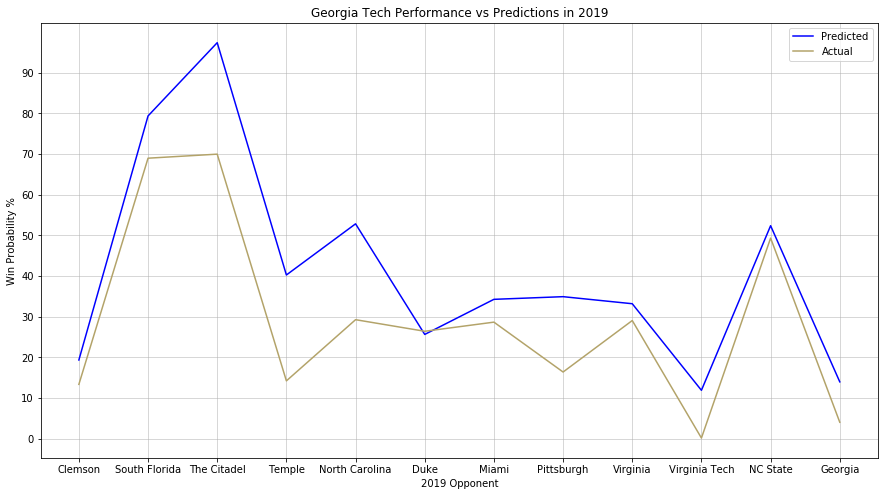

In [50]:
gatech_results = generate_schedule_analysis("Georgia Tech", 2019)
gatech_results
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredWinProb, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.PostGameWinProb, color='#B3a369', label="Actual")
plt.yticks(np.arange(0, 100, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Win Probability %')
plt.legend();

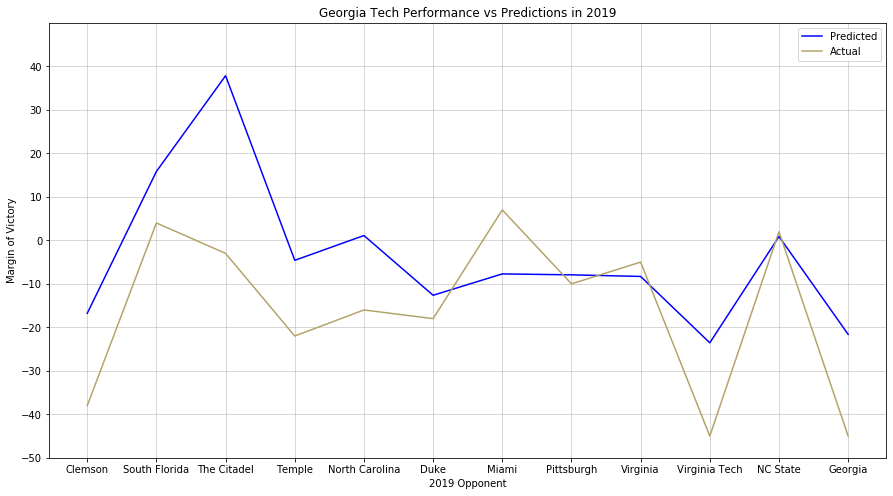

In [51]:
plt.figure(figsize=(15, 8))
plt.plot(gatech_results.Opponent, gatech_results.PredMOV, color='b', label="Predicted")
plt.plot(gatech_results.Opponent, gatech_results.ActualMOV, color='#B3a369', label="Actual")
plt.ylim((-50,50))
plt.yticks(np.arange(-50, 50, step=10))
plt.grid(linestyle='-', linewidth=0.5)
plt.title("Georgia Tech Performance vs Predictions in 2019")
plt.xlabel('2019 Opponent');
plt.ylabel('Margin of Victory');
plt.legend();

Game: Alcorn State @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 41.0
Proj MOV: Georgia Tech by 40.0 (exact value: 40.1349157645828)
Z score: 2.0500488912932826
Win Prob for Georgia Tech: 97.98%
---
Game: Georgia Tech @ South Florida
Actual Winner: South Florida
MOV: South Florida by 11.0
Proj MOV: South Florida by 8.0 (exact value: 8.232067803457294)
Z score: 0.4318808071222212
Win Prob for South Florida: 66.71%
---
Game: Georgia Tech @ Pittsburgh
Actual Winner: Pittsburgh
MOV: Pittsburgh by 5.0
Proj MOV: Pittsburgh by 7.0 (exact value: 7.11903034842472)
Z score: 0.3754256063697567
Win Prob for Pittsburgh: 64.63%
---
Game: Clemson @ Georgia Tech
Actual Winner: Clemson
MOV: Clemson by 28.0
Proj MOV: Clemson by 35.0 (exact value: 34.72002370840674)
Z score: 1.7753961231387747
Win Prob for Clemson: 96.21%
---
Game: Bowling Green @ Georgia Tech
Actual Winner: Georgia Tech
MOV: Georgia Tech by 46.0
Proj MOV: Georgia Tech by 38.0 (exact value: 38.43543344889652)
Z score: 1

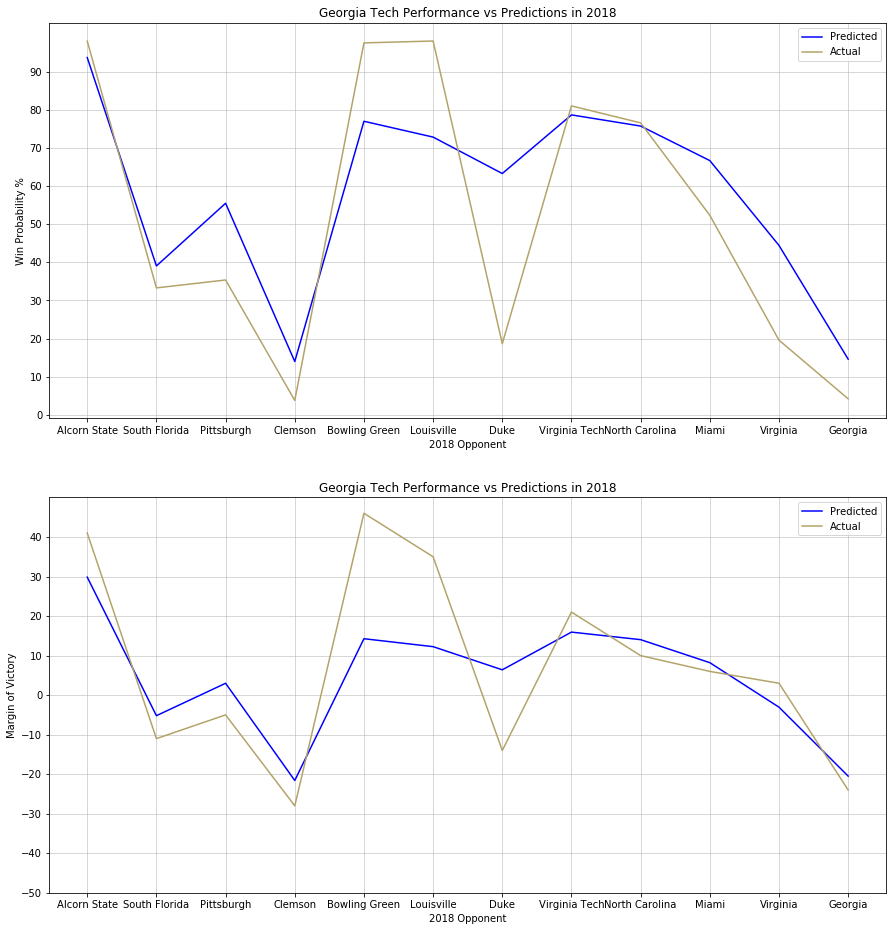

In [52]:
gatech_18_results = generate_schedule_analysis("Georgia Tech", 2018)
fig, axes = plt.subplots(2, figsize=(15,16))

axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PredWinProb, color='b', label="Predicted")
axes[0].plot(gatech_18_results.Opponent, gatech_18_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].plot(gatech_18_results.Opponent, gatech_18_results.PredMOV, color='b', label="Predicted")
axes[1].plot(gatech_18_results.Opponent, gatech_18_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

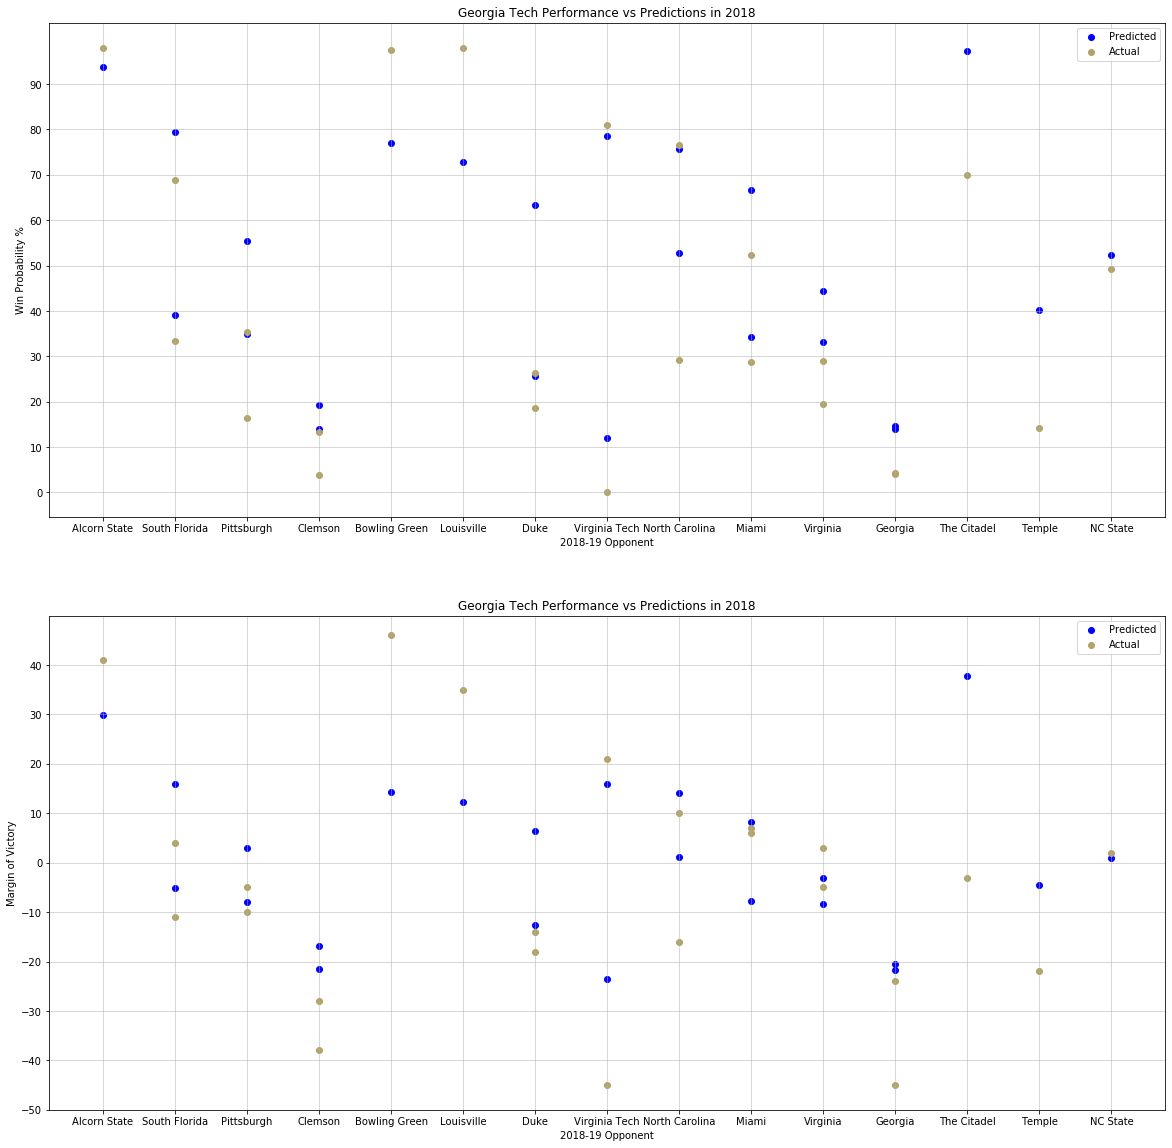

In [53]:
gatech_1819_results = gatech_18_results.append(gatech_results)
fig, axes = plt.subplots(2, figsize=(20,20))
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredWinProb, color='b', label="Predicted")
axes[0].scatter(gatech_1819_results.Opponent, gatech_1819_results.PostGameWinProb, color='#B3a369', label="Actual")
axes[0].set_yticks(np.arange(0, 100, step=10))
axes[0].grid(linestyle='-', linewidth=0.5)
axes[0].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[0].set_xlabel('2018-19 Opponent');
axes[0].set_ylabel('Win Probability %')
axes[0].legend();

axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.PredMOV, color='b', label="Predicted")
axes[1].scatter(gatech_1819_results.Opponent, gatech_1819_results.ActualMOV, color='#B3a369', label="Actual")
axes[1].set_ylim(-50,50)
axes[1].set_yticks(np.arange(-50, 50, step=10))
axes[1].grid(linestyle='-', linewidth=0.5)
axes[1].set_title("Georgia Tech Performance vs Predictions in 2018")
axes[1].set_xlabel('2018-19 Opponent');
axes[1].set_ylabel('Margin of Victory')
axes[1].legend();

In [54]:
# Stability of 5FR measure YoY
grouped_by_season = stored_game_boxes.copy().groupby(['Season', 'Team'])
tings = grouped_by_season.apply(lambda x: x['5FR'].mean())
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Team",'Season','5FRMean']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='5FRMean', index='Team', columns='Season').reset_index()
pivot.corr()

Season,2012,2013,2014,2015,2016,2017,2018,2019
Season,,,,,,,,
2012,1.000000,0.588419,0.525915,0.451663,0.382888,0.294898,0.300102,0.363730
2013,0.588419,1.000000,0.562651,0.366462,0.245886,0.260369,0.185906,0.279507
2014,0.525915,0.562651,1.000000,0.616098,0.486532,0.332827,0.332063,0.386230
2015,0.451663,0.366462,0.616098,1.000000,0.656853,0.472454,0.379344,0.403584
2016,0.382888,0.245886,0.486532,0.656853,1.000000,0.602837,0.417091,0.594324
2017,0.294898,0.260369,0.332827,0.472454,0.602837,1.000000,0.634993,0.569357
2018,0.300102,0.185906,0.332063,0.379344,0.417091,0.634993,1.000000,0.610011
2019,0.363730,0.279507,0.386230,0.403584,0.594324,0.569357,0.610011,1.000000


In [55]:
def clean_prediction_prob_names(row):
    prob = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[0]
    return prob

def clean_prediction_mov_names(row):
    mov = predict_matchup(row.Team, row.Opponent, row.Year - 1, -1, -1)[1]
    return mov

def generate_schedule_predictions(team, opponents = pd.DataFrame(), year = 2019):
    frame = pd.DataFrame(data={"Year":year,"Team":team,"Opponent":opponents.Team, "Site":opponents.Site})
    frame.reset_index(inplace=True, drop=True)
    frame['PredWinProb'] = frame.apply(lambda y: clean_prediction_prob_names(y) * 100, axis=1)
    frame['PredMOV'] = frame.apply(lambda y: clean_prediction_mov_names(y), axis=1)
    return frame


opp_2020_df = pd.DataFrame(data={
    "Team" : ["UCF","Auburn","James Madison","Connecticut","Boston College","Duke","Miami","Georgia Tech","NC State","Pittsburgh","Virginia Tech","Virginia"],
    "Site" : ["Away","Home","Home","Home","Away","Away","Away","Home","Home","Home","Home","Away"]
})
georgia_tech_2020 = generate_schedule_predictions("North Carolina", opp_2020_df, 2020)
georgia_tech_2020

,Year,Team,Opponent,Site,PredWinProb,PredMOV
0,2020,North Carolina,UCF,Away,37.434535,-6.598792
1,2020,North Carolina,Auburn,Home,30.132450,-10.546382
2,2020,North Carolina,James Madison,Home,97.784643,39.368470
3,2020,North Carolina,Connecticut,Home,75.453491,13.297929
4,2020,North Carolina,Boston College,Away,46.683877,-1.923333
5,2020,North Carolina,Duke,Away,49.183645,-0.686104
6,2020,North Carolina,Miami,Away,38.345769,-6.126526
7,2020,North Carolina,Georgia Tech,Home,60.482538,4.958843
8,2020,North Carolina,NC State,Home,56.683958,3.036126
9,2020,North Carolina,Pittsburgh,Home,48.856231,-0.847959


In [56]:
generate_win_prob(401135282, 2019)
box2 = calculate_box_score(401135282, 2019)
# testDiffs = ["Team",'5FRDiff']
print(box2[["Team","FP","FPDiff"]])
break_down_box_score(box2)

Could not find basic game data for game_id 401135282 locally, checking CFB Data API
Could not find drive data for game_id 401135282 locally, checking CFB Data API
Could not find play by play data for game_id 401135282 locally, checking CFB Data API
Game: Florida @ Virginia
Actual Winner: Florida
MOV: Florida by 8
Proj MOV: Florida by -6.0 (exact value: -5.594487683095205)
Z score: -0.2694261993752077
Win Prob for Florida: 39.38%
---
Could not find basic game data for game_id 401135282 locally, checking CFB Data API
Could not find drive data for game_id 401135282 locally, checking CFB Data API
Could not find play by play data for game_id 401135282 locally, checking CFB Data API
       Team         FP    FPDiff
0   Florida  22.250000 -7.204545
1  Virginia  29.454545  7.204545


,Team,Eff,Expl,FinDrv,FldPos,Trnovr,5FR,5FRDiff
0,Florida,4.872312,4.998002,4.970375,4.279545,4.99888,4.878109,-0.243783
1,Virginia,5.127688,5.001998,5.029625,5.720455,5.00112,5.121891,0.243783


In [57]:
predict_matchup("Oregon","Wisconsin", 2012, -1)

[0.41788549478859904, -4.369759905907648]

In [58]:
line_data = pd.DataFrame()

for i in range(2013, 2020):
    ln = retrieveCfbDataFile('lines',i)
    ln['year'] = i
    line_data = line_data.append(ln, sort=False)
    
print(f"Spreads imported: {len(line_data)}")

Spreads imported: 17274


In [59]:
def assign_favorite(row):
    if (row.RawSpread < 0):
        return row.HomeTeam
    else:
        return row.AwayTeam

def simplify_prediction_names_prob(row):
#     print(row.GameID)
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    prob = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[0]
    return prob

def simplify_prediction_names_mov(row):
    weeks = opponent_game_ids[(opponent_game_ids.Season == row.Season) & (opponent_game_ids.Team == row.HomeTeam) & (opponent_game_ids.Opponent == row.AwayTeam)].Week.to_list()
    week = int(weeks[0]) if (len(weeks) > 0) else -1
    mov = predict_matchup(row.HomeTeam, row.AwayTeam, row.Season, week = week)[1]
    return mov
    
def determine_ml_win(row):
    winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.MLPick) else "No"

def determine_ats_win(row):
    mov = (row.HomeScore - row.AwayScore) if (row.Favorite == row.HomeTeam) else (row.AwayScore - row.HomeScore)
    if (row.RawSpread < 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.HomeTeam if (mov > row.BetMOV) else row.AwayTeam
    elif (row.RawSpread > 0):
        if (mov == row.BetMOV):
            return "Push"
        winner = row.AwayTeam if (mov > row.BetMOV) else row.HomeTeam
    else:
        winner = row.HomeTeam if (row.HomeScore > row.AwayScore) else row.AwayTeam
    return "Yes" if (winner == row.ATSPick) else "No"

# Notes: no betting data for 2012, no box scores for 2014
def simulate_season(year):
    print(f"[Simulation] Retrieving box score entries for {year} season...")
    game_ids = stored_game_boxes[(stored_game_boxes.Season == year)].GameID.drop_duplicates().to_list()
    print(f"[Simulation] Retrieved {len(game_ids)} box scores for {year} season, pulling betting lines...")
    lines = line_data[(line_data.year == year) & (line_data.lineProvider == 'consensus') & (line_data.id.isin(game_ids))]
    print(f"[Simulation] Retrieved {len(lines)} games with betting lines for {year} season.")
    print(f"[Simulation] Creating projections for {len(lines)} games and analyzing spreads...")
    produced = pd.DataFrame(data={"GameID" : lines.id, "Season": year,"HomeTeam": lines.homeTeam,"HomeScore": lines.homeScore, "AwayTeam": lines.awayTeam, "AwayScore": lines.awayScore,"RawSpread":lines.spread, "BetMOV":abs(lines.spread)})
    if (len(lines) > 0):
        produced['Favorite'] = produced.apply(lambda x: assign_favorite(x), axis = 1)
        produced['ProjWinProb'] = produced.apply(lambda y: simplify_prediction_names_prob(y) * 100, axis=1)
        produced['ProjMOV'] = produced.apply(lambda y: simplify_prediction_names_mov(y), axis=1)
        produced['ProjCoverStatus'] = produced.apply(lambda z: z.ProjMOV > z.BetMOV, axis=1)
        produced['MLPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > 0) else z.AwayTeam, axis=1)
        produced['ATSPick'] = produced.apply(lambda z: z.HomeTeam if (z.ProjMOV > z.BetMOV) else z.AwayTeam, axis=1)
        produced['MLWin'] = produced.apply(lambda z: determine_ml_win(z), axis = 1)
        produced['ATSWin'] = produced.apply(lambda z: determine_ats_win(z), axis = 1)
        print(f"[Simulation] Finished creating spread analysis.")
    else:
        print(f"[Simulation] Unable to do spread analysis without data for {year} season.")
    
    return produced

def run_ats_simulations(year):
    simmed = simulate_season(year)
    if (len(simmed) > 0):
        results = pd.DataFrame(data={"pick_category":["ML","ATS"], "season" : year})
        results["W"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Yes")]), axis=1)
        results["L"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "No")]), axis=1)
        results["D"] = results.apply(lambda x: len(simmed[(simmed[f"{x.pick_category}Win"] == "Push")]), axis=1)
        results["WinPct"] = verify_division(results.W, len(simmed)) # ATS break-even point (assuming -110 odds): 52.4%, ATS profit point: 54.5%
        return results
    else:
        print(f"[Simulation] Unable to run season simulation due to lack of data for {year} season.")
        return None

In [60]:
historic_validation = pd.DataFrame()
for i in range(2013, 2020):
    df = run_ats_simulations(i)
    historic_validation = historic_validation.append(df)
historic_validation

[Simulation] Retrieving box score entries for 2013 season...
[Simulation] Retrieved 700 box scores for 2013 season, pulling betting lines...
[Simulation] Retrieved 692 games with betting lines for 2013 season.
[Simulation] Creating projections for 692 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2014 season...
[Simulation] Retrieved 697 box scores for 2014 season, pulling betting lines...
[Simulation] Retrieved 648 games with betting lines for 2014 season.
[Simulation] Creating projections for 648 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simulation] Retrieving box score entries for 2015 season...
[Simulation] Retrieved 709 box scores for 2015 season, pulling betting lines...
[Simulation] Retrieved 675 games with betting lines for 2015 season.
[Simulation] Creating projections for 675 games and analyzing spreads...
[Simulation] Finished creating spread analysis.
[Simula

,pick_category,season,W,L,D,WinPct
0,ML,2013,537,155,0,0.776012
1,ATS,2013,383,301,8,0.553468
0,ML,2014,501,147,0,0.773148
1,ATS,2014,399,233,16,0.615741
0,ML,2015,532,143,0,0.788148
1,ATS,2015,395,262,18,0.585185
0,ML,2016,522,154,0,0.772189
1,ATS,2016,400,258,18,0.591716
0,ML,2017,562,158,0,0.780556
1,ATS,2017,420,280,20,0.583333


In [61]:
def generate_validation_metrics(category):
    avg = historic_validation[(historic_validation.pick_category == category)].WinPct.mean()
    print(f"Avg {category} Win %: {avg}")
    
generate_validation_metrics("ML")
generate_validation_metrics("ATS")

Avg ML Win %: 0.7737173256747614
Avg ATS Win %: 0.5805248472275456


In [62]:
# Model Export snippet

# import pickle
# from datetime import datetime
# now = datetime.now()
# filename = now.strftime("%d-%b-%Y-%H:%M:%S")
# pkl_filename = f"results/wp_model-{filename}.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(model, file)

In [63]:
generate_win_prob(401135285, 2019)

Could not find basic game data for game_id 401135285 locally, checking CFB Data API
Could not find drive data for game_id 401135285 locally, checking CFB Data API
Could not find play by play data for game_id 401135285 locally, checking CFB Data API
Game: Utah @ Texas
Actual Winner: Texas
MOV: Texas by 28
Proj MOV: Texas by 22.0 (exact value: 22.111951354783557)
Z score: 1.1358927060641324
Win Prob for Texas: 87.20%
---


[0.871999264347759, 28]